In [1]:
### Imported libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp 
import scipy.sparse as sps
import scipy.optimize as optimization
from tqdm import tqdm

%matplotlib inline

# **QUANTUM ISING CHAIN - Hands on by Giuseppe Santoro**


## Introduction
This Notebook contains the assignments done by Edoardo Alessandroni and Riccardo Andreoni for the Hands-on course on Quantum Ising Chains by Giuseppe Santoro. All defined routines and functions can be found below, in paragraph 0), while the results are presented in specific paragraphs, one for each assignment. 

# **0) Routines**

In [2]:
### Assignment 1

def build_AB(L_, par_, PBC_, p_):
    """Builds blocks A and B for the defintion of H
    par = (J, h, x)"""
    J_, h_, x_ = par_

    if type(J_) == int or float:
        J_ = J_*np.ones((L_))
    
    assert len(J_) == L_, "J must be L-long"

    A = sps.dok_matrix((L_, L_), dtype=np.float32)
    B = sps.dok_matrix((L_, L_), dtype=np.float32)
    
    A.setdiag(h_)
    A.setdiag(-J_[:-1]/2, k=1 )
    A.setdiag(-J_[:-1]/2, k=-1)
    
    B.setdiag(-x_*J_[:-1]/2, k=1)
    B.setdiag(x_*J_[:-1]/2, k=-1)
    
    if PBC_:
        A[0,-1] = (-1)**p_*J_[-1]/2
        A[-1,0] = (-1)**p_*J_[-1]/2
        
        B[0,-1] = -(-1)**p_*x_*J_[-1]/2
        B[-1,0] = (-1)**p_*x_*J_[-1]/2
    
    return A,B

def build_Hmat(L_, par_, PBC_, p_):
    """Builds the Hamiltonian matrix
    par = (J, h, x)"""
    A, B = build_AB(L_, par_, PBC_, p_)
    
    TL = sps.csr_matrix(np.array([[1,0],[0,0]]))
    TR = sps.csr_matrix(np.array([[0,1],[0,0]]))
    BR = sps.csr_matrix(np.array([[0,0],[0,1]]))

    H = sps.kron(TL,A)
    H += sps.kron(BR,-A.conjugate())
    H += sps.kron(TR,B)
    H += sps.kron(TR.transpose(),-B.conjugate())
    
    return H

######################################

def spectrum(L_, par_, PBC_, p_):
    """Spectrum of a QIC
    par = (J, h, x)"""
    H = build_Hmat(L_, par_, PBC_, p_)
    eig = sp.linalg.eigvalsh(H.toarray())
    return eig

In [3]:
### Assignment 2

def clean_eigenv(L_, w1_, w2_):
    """Brings the zero-eigenspace in the correct form"""
    
    # Swap matrices
    Id = sps.dok_matrix((L_,L_))
    Id.setdiag(1)
    S = sps.kron(sps.csr_matrix(np.array([[0,1],[1,0]])), Id)

    a = S@(w1_ + w2_) + (w1_ + w2_)
    b = S@(w1_ - w2_) - (w1_ - w2_)
    a /= np.linalg.norm(a)
    b /= np.linalg.norm(b)
    
    u = (a + b)
    v = (a - b)
    u /= np.linalg.norm(u)
    v /= np.linalg.norm(v)
    return u, v

def orthogonalize(L_, E_, V_):
    """Orthogonalization routine for the degenerate zero eigenspace"""
    if not np.any(np.abs(E_)<1e-6):
        return E_, V_
    
    indx = np.argwhere(np.abs(E_)<1e-6).flatten()
    if len(indx)!=2: #check eigenspace_dimension=2
        raise ValueError(f"Wrong number of zero eigenvalues: {len(indx)}")

    w1, w2 = clean_eigenv(L_, V_[:,indx[0]], V_[:,indx[1]])
    
    Eorth = E_
    Vorth = V_
    Vorth[:,indx[0]], Vorth[:,indx[1]] = w1, w2

    return Eorth, Vorth

def organize(vec, mat):
    L = int(len(vec)/2)
    # Organize vec
    VEC = np.ndarray((2*L))
    VEC[:L] = vec[L:]
    VEC[L:] = vec[:L][::-1]
    # Organize mat
    MAT = np.ndarray((2*L, 2*L))
    MAT[:,:L] = mat[:,L:]
    MAT[:,L:] = mat[:,:L][:,::-1]
    return VEC, MAT


def diagonalize(L_, par_, PBC_, p_, org=True):
    """Spectrum and eigenstates of a QIC, with cleaning process for the two-degenerate zero-eigenspace
        par = (J, h, x)

        org=True by default ---> ( positive(ascending) , negative(descending) )
        org=False         -----> ( negative(ascending) , positive(ascending)  )"""
    
    # Build Hmat
    H = build_Hmat(L_, par_, PBC_, p_)
    # Diagonalize
    e, s = sp.linalg.eigh(H.toarray())
    # Orthogonalize zero-energy eigenspace
    e, s = orthogonalize(L_, e, s)
    # Organize in desired shape
    if(org):
        e,s = organize(e, s)
    
    return e, s



In [4]:
### Assignment 3

# Inverse baseline fit for upper bounds
def als(y, p=0.99, lam=0.01, niter=50):
  L = len(y)
  D = sps.csc_matrix(np.diff(np.eye(L), 2))
  w = np.ones(L)
  for i in np.arange(niter):
    W = sps.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = sps.linalg.spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

def bound(x, l, csi, C):
  return C*np.exp(-np.abs(x-l)/csi)

def fit_upper_bound(L_, y):
  l = np.argwhere(np.max(y)==y)
  y = als(y)
  par, _ = sp.optimize.curve_fit(bound, np.arange(L_), y, p0=[l[0,0], 1, 1])
  return par


In [5]:
### Assignment 4

def compute_GF(U_, V_):
    return U_@(U_.conjugate().T), U_@(V_.conjugate().T)

def compute_M(U_, V_):
    G_, F_ = compute_GF(U_, V_)
    L_ = np.shape(U_)[0]
    return np.eye(L_) - 2*(G_+F_)

def compute_M_frmsys(L_, par_, PBC_, p_):
    _, UU_ = diagonalize(L_, par_, PBC_, p_)
    U_ = UU_[:L_, :L_]
    V_ = UU_[L_:, :L_]
    # Compute correlation function
    return compute_M(U_, V_) 

def compute_corr(j1_, j2_, M_):
    if j1_>j2_:
        j1_,j2_ = j2_,j1_
    M_red = M_[j1_:j2_, j1_+1:j2_+1]
    # print(np.shape(M_red), j1_, j2_)
    # print(M_)
    return np.linalg.det(M_red)


In [6]:
### Assignment 5

def compute_lambda(G_, F_, l_):
    TR = sps.csr_matrix(np.array([[0,1],[0,0]]))
    BL = TR.T
    Id = np.eye(l_)
    Gl_ = G_[:l_, :l_]
    Fl_ = F_[:l_, :l_]
    A_ = sps.kron(TR, - Id + 2*(Gl_ - Fl_))
    A_ += sps.kron(BL, Id - 2*(Gl_ + Fl_))
    return np.linalg.eigvalsh(A_.toarray()*1j)

def compute_lambda_frmsys(L_, par_, PBC_, p_, l_):
    assert l_<=L_, "Subsystem size l_ must be l_<=L_"
    _, UU_ = diagonalize(L_, par_, PBC_, p_)
    U_ = UU_[:L_, :L_]
    V_ = UU_[L_:, :L_]
    G_, F_ = compute_GF(U_, V_) 
    return compute_lambda(G_, F_, l_)

######################################

def entropy(spctrm_):
    spctrm_ = spctrm_[spctrm_>-1.+1e-14]
    return -np.sum( (1+spctrm_)/2 * np.log((1+spctrm_)/2) )
    

# **1) Assignment**: Plot of spectrum for a uniform Ising chain in different regimes of transverse field

#### 1.1) Fixed $h$ spectrum analysis

In [7]:
### Fixed h: spectrum 

L = 256
J = 1.
x = 1

PBC = False
p = 0

hs = np.array([2., 1., 0.5])

#####################################

E = np.ndarray((len(hs), 2*L))

for i,h in enumerate(hs):
    e = spectrum(L, (J, h, x), PBC, p)
    E[i] = np.sort(e)/J

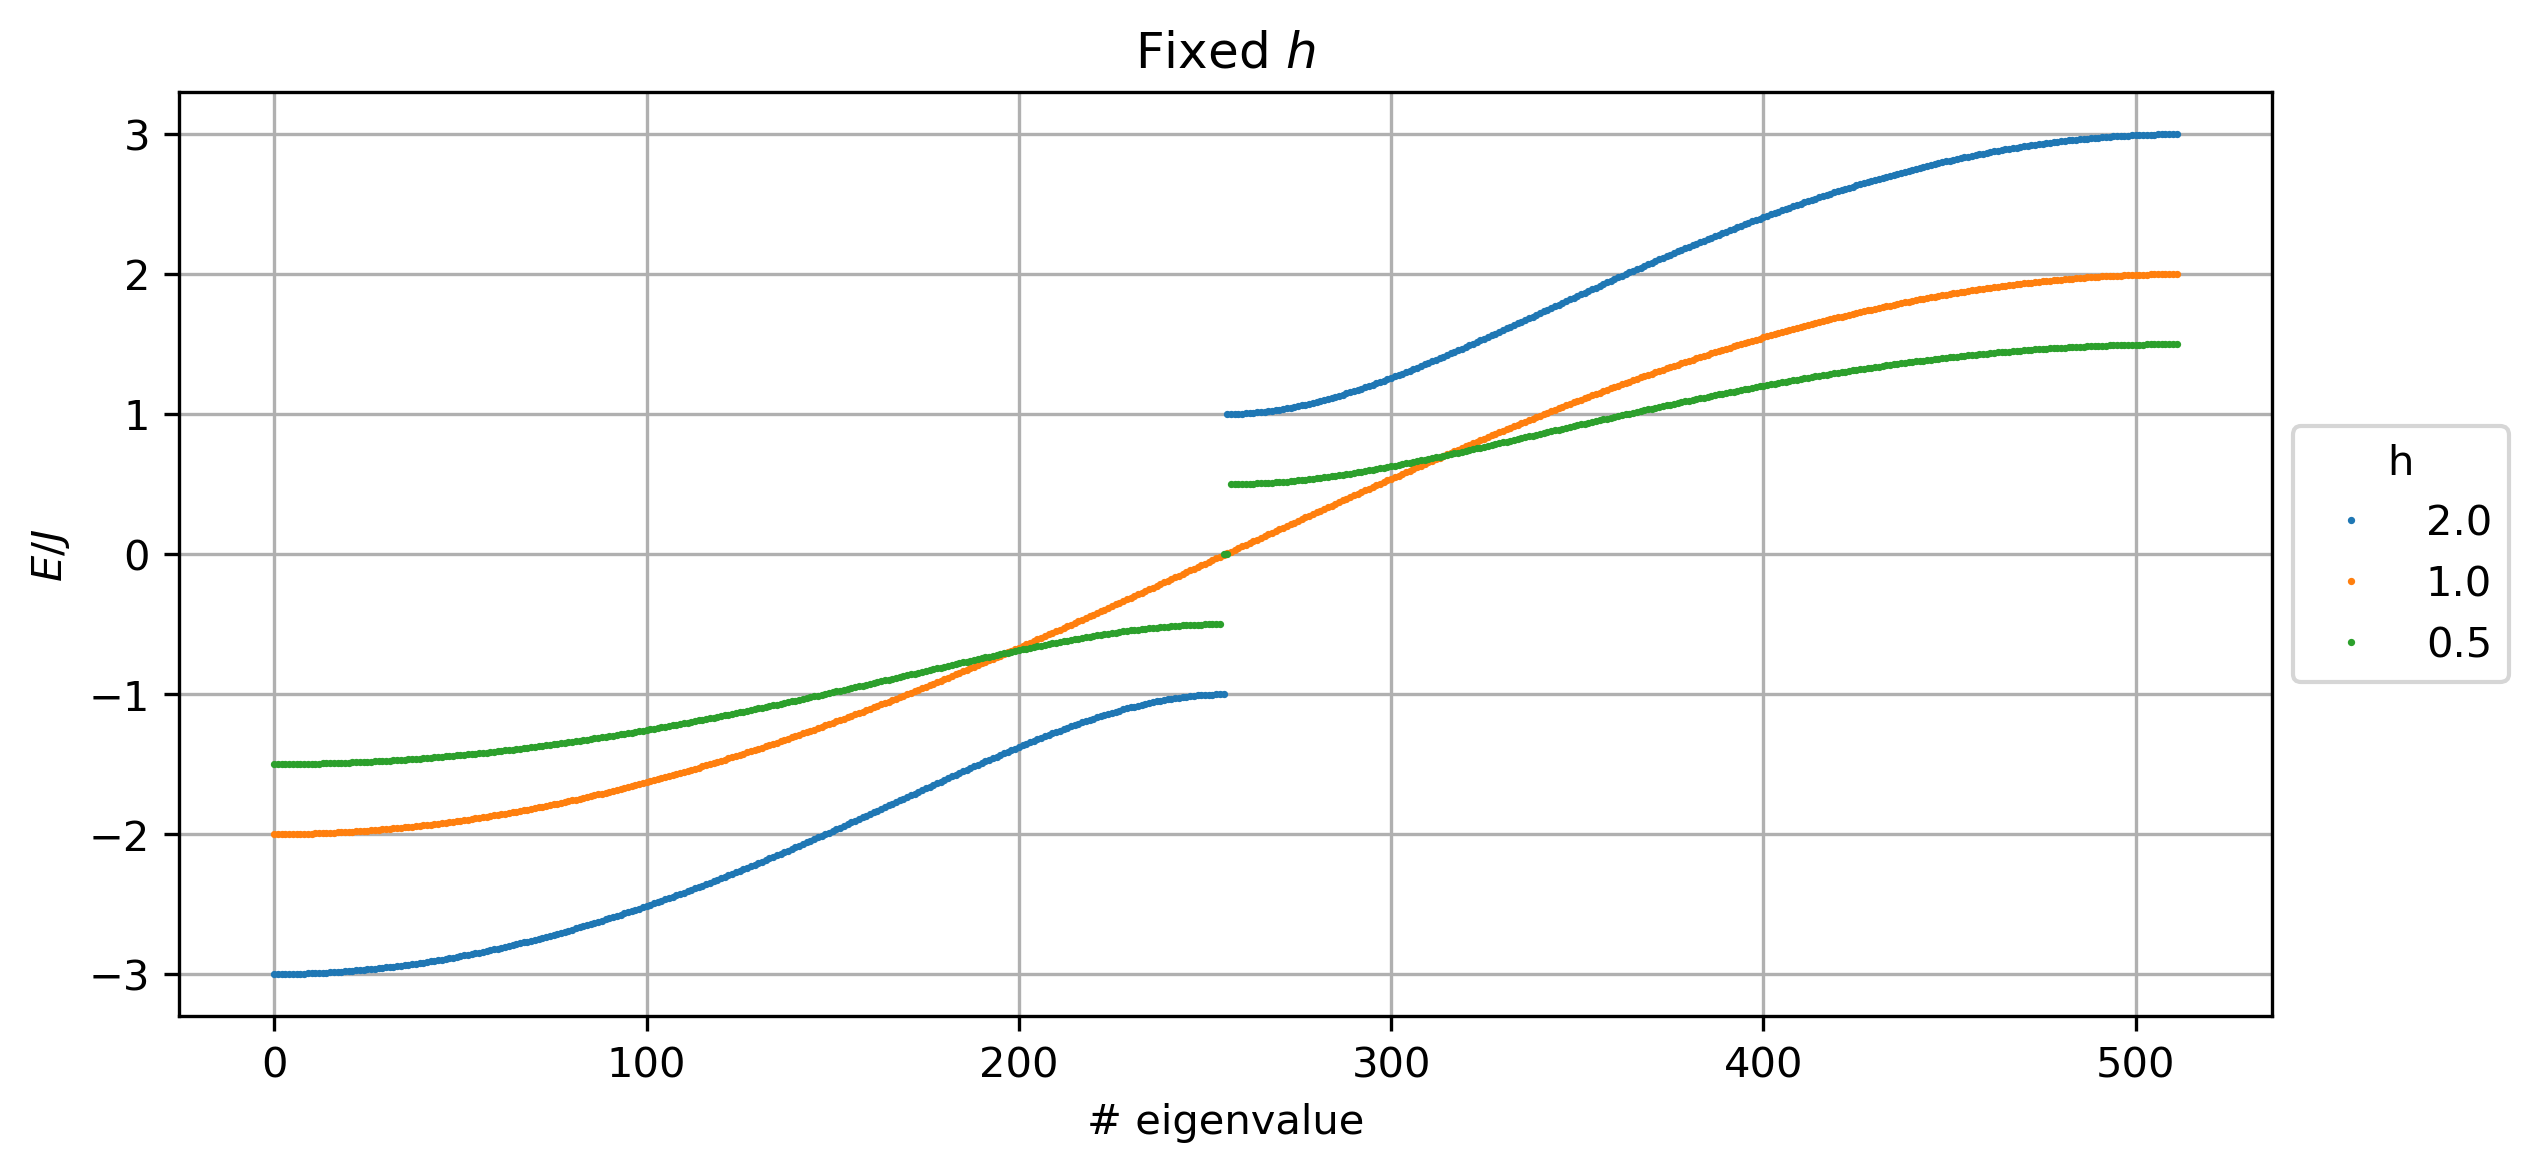

In [8]:
### Fixed h: plot
fig = plt.figure(figsize=(9, 4), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.set_title(r"Fixed $h$")
plt.xlabel(r"# eigenvalue")
plt.ylabel(r"$E/J$")
for i in range(len(hs)):
    plt.plot(np.arange(len(E[i])), E[i], ".", markersize = 1.5, label = str(hs[i]))
plt.grid()
ax.legend(title = "h", loc = "center left", bbox_to_anchor = (1, .5))
plt.show()

#### 1.2) Eigenvalues behaviour at variable $h$

In [9]:
### Variable h: spectrum

L = 256
J = 1.
x = 1

PBC = False
p = 0

Nh = 101
hs = np.linspace(0., 2., Nh)

#####################################

E = np.ndarray((len(hs), 2*L))

for i,h in enumerate(hs):
    e = spectrum(L, (J, h, x), PBC, p)
    E[i] = np.sort(e)/J

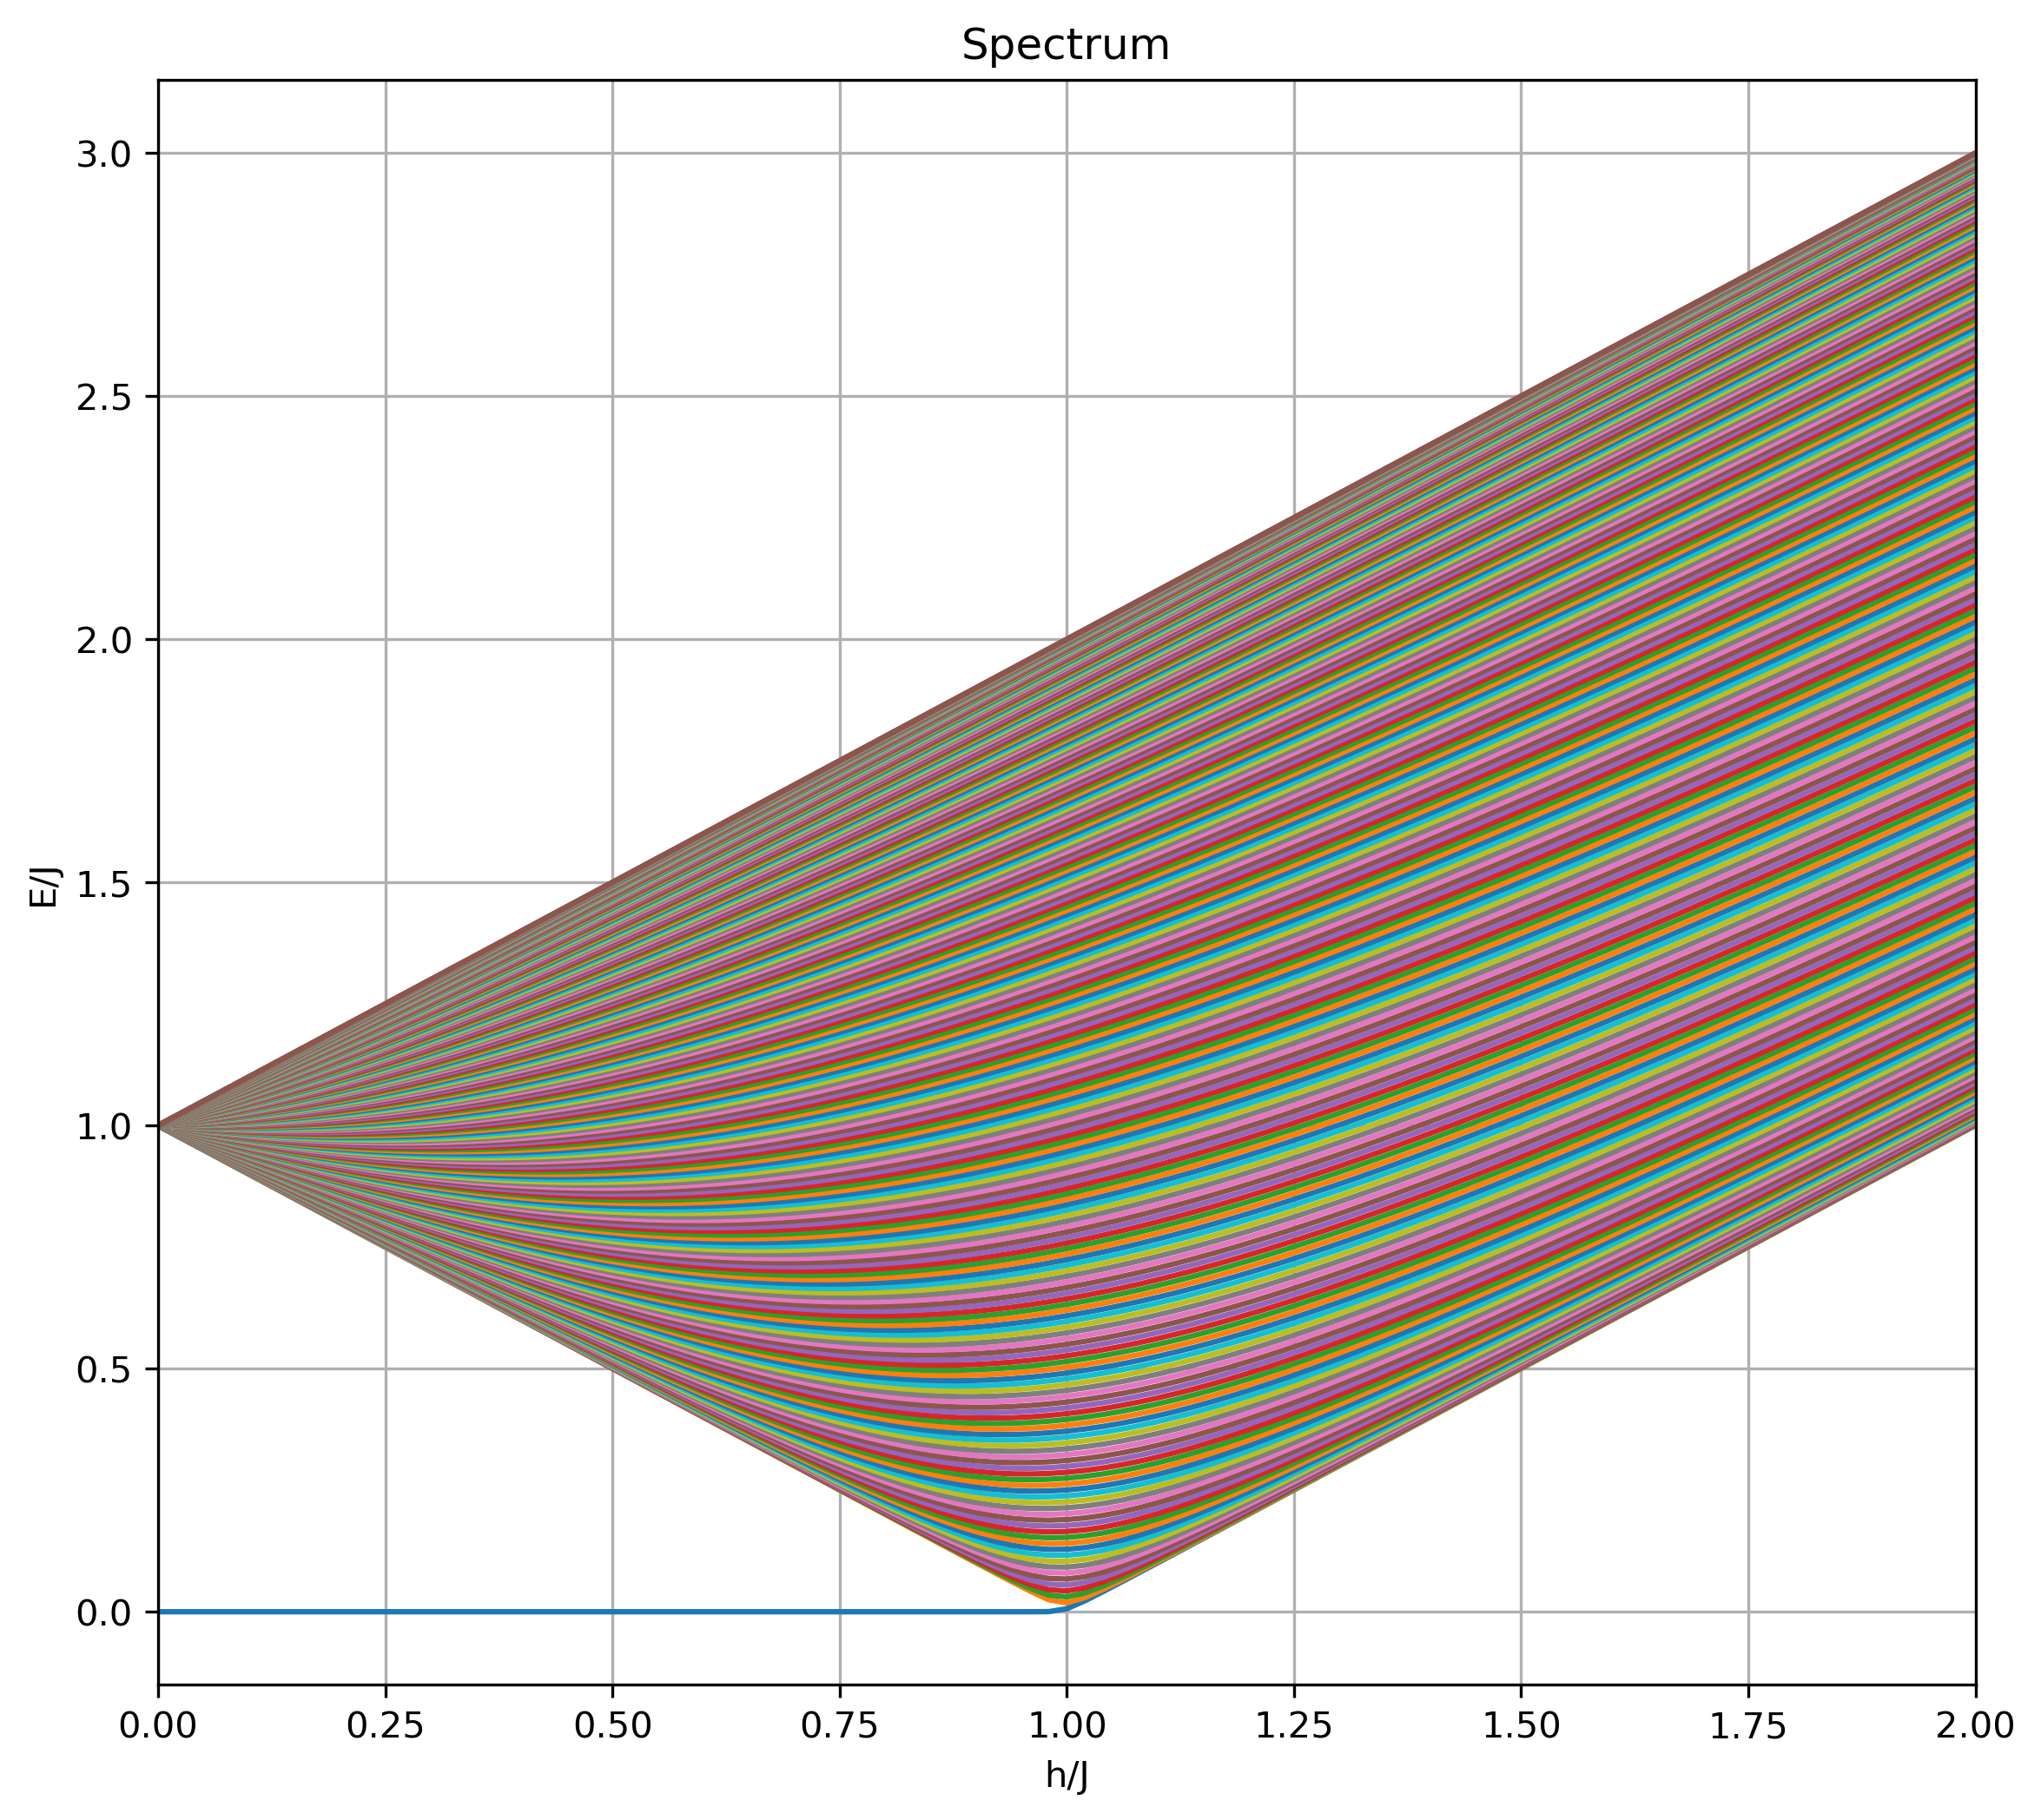

In [10]:
### Variable h: plot

fig = plt.figure(figsize=(9, 8), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.set_title(r"Spectrum")
ax.set_xlabel(r"h/J")
ax.set_ylabel(r"E/J")
ax.set_xlim(0, 2)
plt.grid()
for i in range(L, 2*L):
    plt.plot(hs/J, E[:,i], "-", markersize = .7)
plt.show()

# **2) Assignment**: Write a function Diagonalize(H) which organizes the matrix of eigenvectors in the convenient way

In [11]:
### Diagonalization + cleaning degenerate eigenspace + check unitarity

L = 2
J = 1.
x = 1

h = 0.5

PBC = False
p = 0

#####################################

eigval, eigvec = diagonalize(L, (J, h, x), PBC, p)

#####################################

print("Checking unitarity for L=" ,L, "and h=", h, "...")

check = eigvec@(eigvec.transpose()).conjugate()-np.eye(2*L)
if np.any(check>1e-8):
    print("\tUnitarity not satisfied")
else:
    print("\tUnitarity checked: ok")


Checking unitarity for L= 2 and h= 0.5 ...
	Unitarity checked: ok


Let's explicitly show that by applying the routine ``organize`` to the eigenvalues and eigenvectors one obtains the desired shape of $\mathbb{U}$:
$$
\mathbb{U} = \begin{pmatrix}
\mathbf{u_1} &\cdots &\mathbf{u_1} &\mathbf{v_1}^* &\cdots &\mathbf{v_L}^*\\
\mathbf{v_1} &\cdots &\mathbf{v_L} &\mathbf{u_1}^* &\cdots &\mathbf{u_1}^* 
\end{pmatrix} = \begin{pmatrix}
\mathbf{U} &\mathbf{V^*}\\
\mathbf{V} &\mathbf{U^*}
\end{pmatrix}
$$

In [12]:
### Show action of organization routine

L = 2
J = 1.
x = 1

h = 0.5

PBC = False
p = 0

#####################################

eigval1, eigvec1 = diagonalize(L, (J, h, x), PBC, p, org=False)
eigval2, eigvec2 = diagonalize(L, (J, h, x), PBC, p)

print("       -> Eigenvectors: <-       ", "\t\t", "       -> Eigenvalues: <-        ")
print("          ------------           ", "\t\t", "          -----------            ")
print( eigvec1.round(3), "\t\t", eigval1.round(3))
print()
print("                | (organize)     ", "\t\t", "     (organize) |                ")
print("                v                ", "\t\t", "                v                ")
print()
print( eigvec2.round(3), "\t\t", eigval2.round(3))

       -> Eigenvectors: <-        		        -> Eigenvalues: <-        
          ------------            		           -----------            
[[-0.271  0.271  0.653  0.653]
 [-0.271 -0.271  0.653 -0.653]
 [ 0.653  0.653  0.271 -0.271]
 [-0.653  0.653 -0.271 -0.271]] 		 [-1.207 -0.207  0.207  1.207]

                | (organize)      		      (organize) |                
                v                 		                 v                

[[ 0.653  0.653  0.271 -0.271]
 [ 0.653 -0.653 -0.271 -0.271]
 [ 0.271 -0.271  0.653  0.653]
 [-0.271 -0.271  0.653 -0.653]] 		 [ 0.207  1.207 -0.207 -1.207]


# **3) Assignment**: Anderson localisation of states for the disordered Ising chain
We consider the model with disorder in both $J_j$ and $h_j$, assuming that $J_{j}\in[J_\mathrm{min}; 1]$ and $h_j\in [0; h_\mathrm{max}]$ are uniformly distributed, with $J_\mathrm{min} > 0$.  

We can show that the eigenstates are **localized**, i.e that, fixing $h_\mathrm{max}$ and $J_\mathrm{min}$, there exists a localisation length $\xi_{\mathrm{loc}}$ such that
$$|\mathbf{W}_{j\mu}| = \sqrt{|\mathbf{U}_{j\mu}|^2+|\mathbf{V}_{j\mu}|^2}\leq Ce^{-|j-l_\mu|/\xi_{\mathrm{loc}}}\qquad\forall\mu,$$
where where $l_\mu$ depends on $\mu$ and $C$ is a constant, while $W_{j\mu}$ is the spinor wavefunction of the $\mu$-th eigenstate:
$$\mathbf{W}_{j\mu}=\begin{pmatrix}
    \mathbf{U}_{j\mu}\\
    \mathbf{V}_{j\mu}
\end{pmatrix},$$

#### 3.1) Localized wavefunctions

In [13]:
### Compute wavefunctions and inverse partecipation ratios

L_ = 256
x = 0
PBC = True
p = 1

# Random stuff
np.random.seed(42)

# Define couplings
Jmin = 0.
hmax = 1.
h = np.random.uniform(0, hmax, L_)
J = np.random.uniform(Jmin, 1, L_)

# Diagonalization
E, U = diagonalize(L_, (J, h, x), PBC, p)

# Define W, |W| IPR
W = U[:,:L_] # W_j,mu
nW = np.sqrt( np.power(W[:L_], 2) + np.power(W[L_:], 2) ) # |W_j,mu|
IPR = np.sum(np.power(nW, 4), axis=0) # IPR_mu

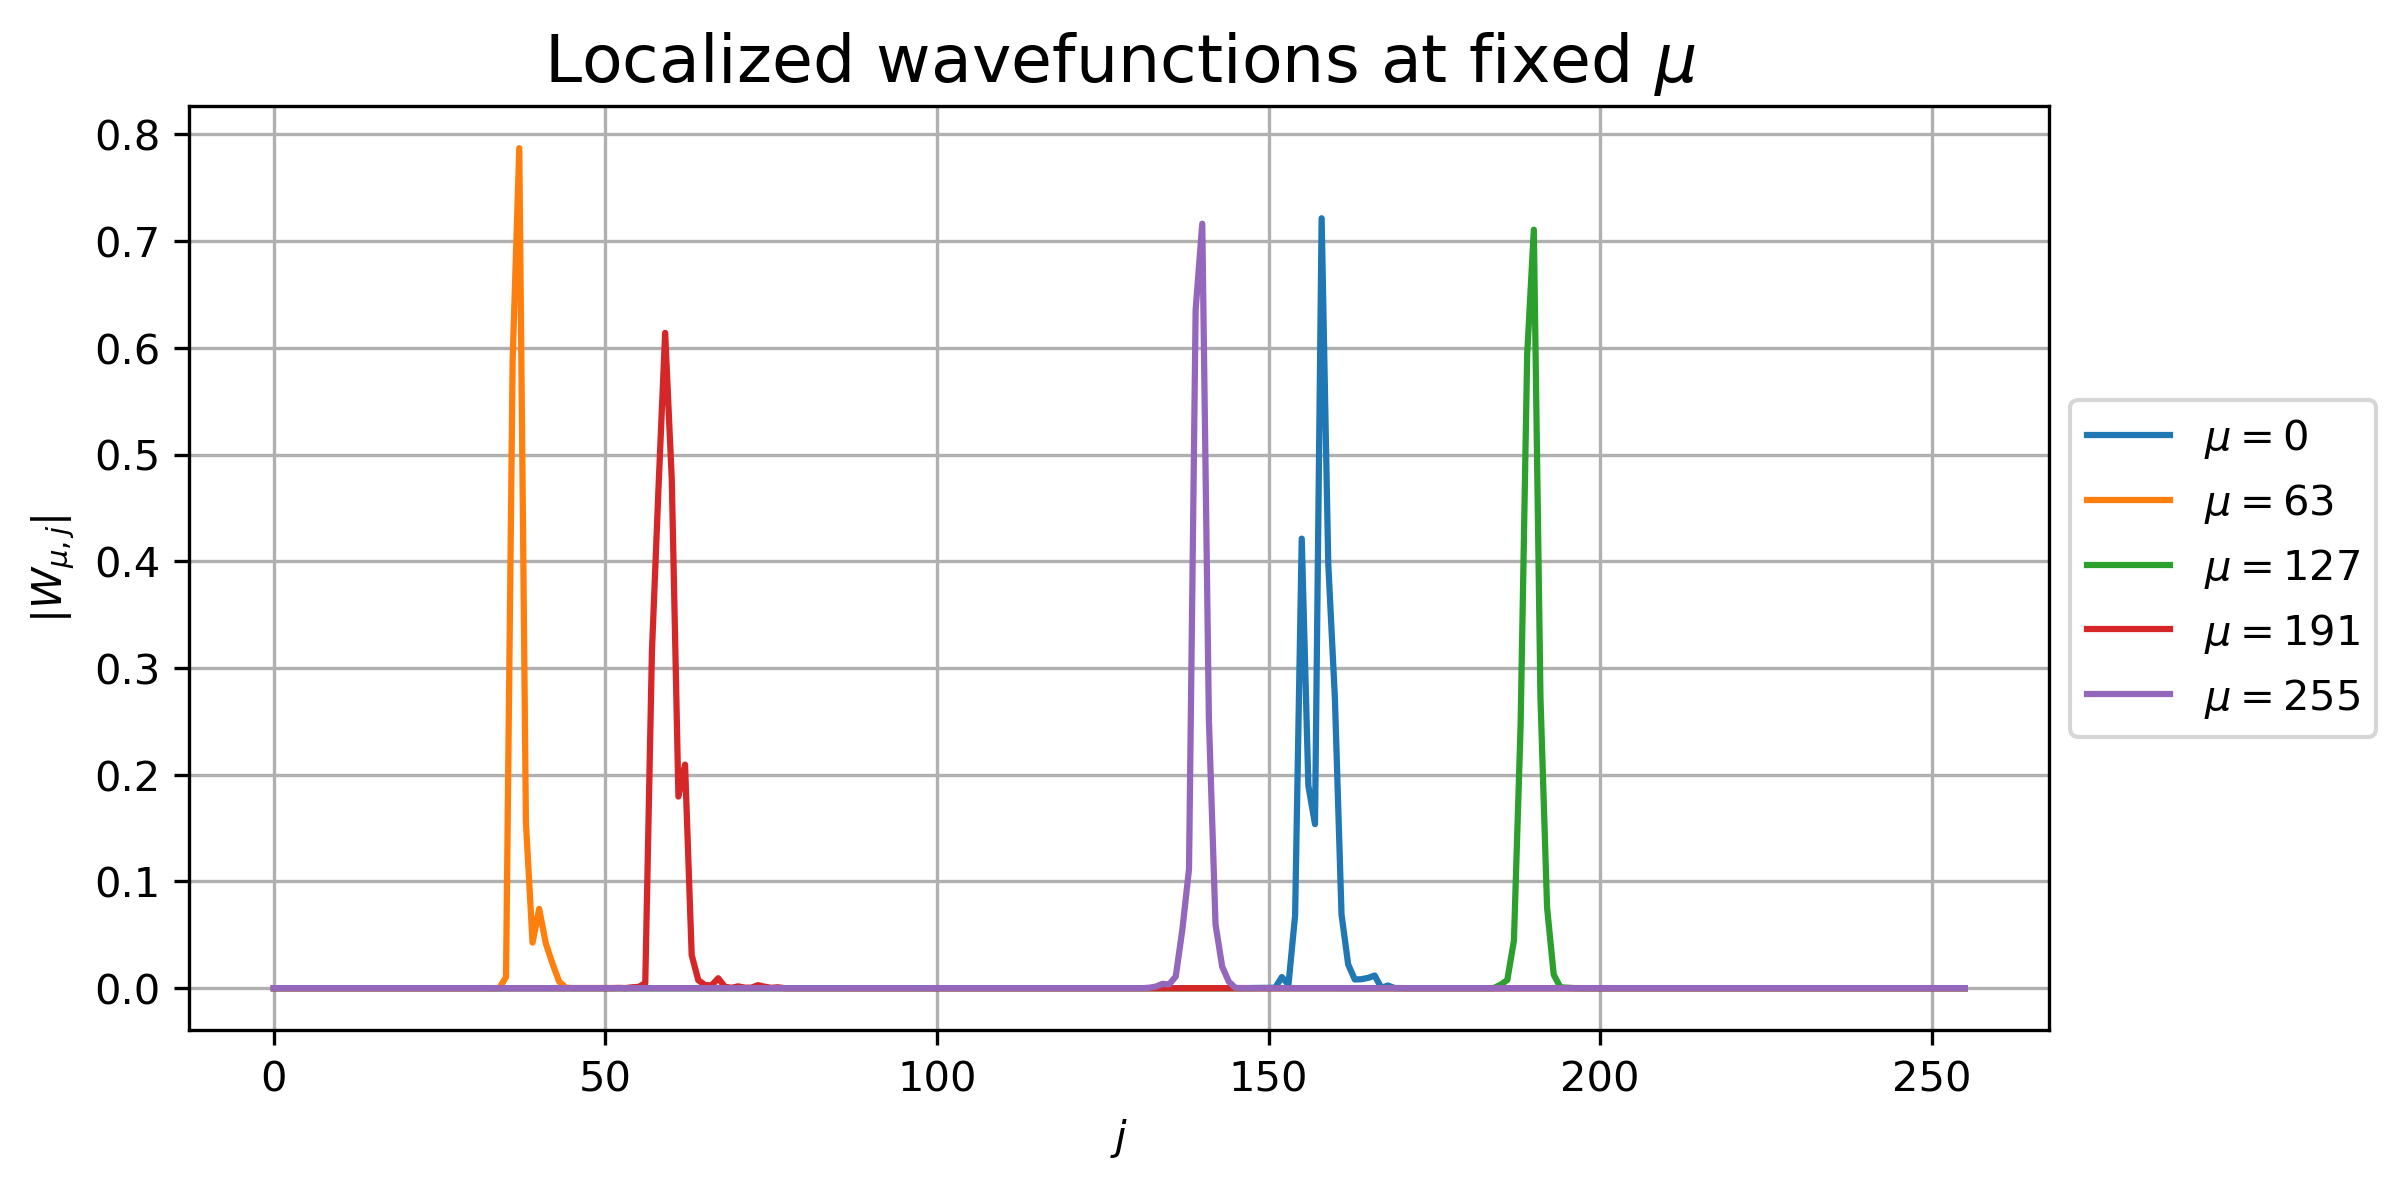

In [14]:
### Plot |W| as function of j, for some values of mu and for a certain disorder

mu = np.linspace(0,L_-1,5).astype(int)

# Plot
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.set_title(r"Localized wavefunctions at fixed $\mu$", fontsize=16)
plt.xlabel(r"$j$")
plt.ylabel(r"$|W_{\mu,j}|$")

for m in mu:
    plt.plot(np.arange(L_), nW[:,m], "-", linewidth=1.5, label=r"$\mu=${}".format(m) )

plt.grid()
ax.legend(loc = "center left", bbox_to_anchor = (1, .5))

plt.show()

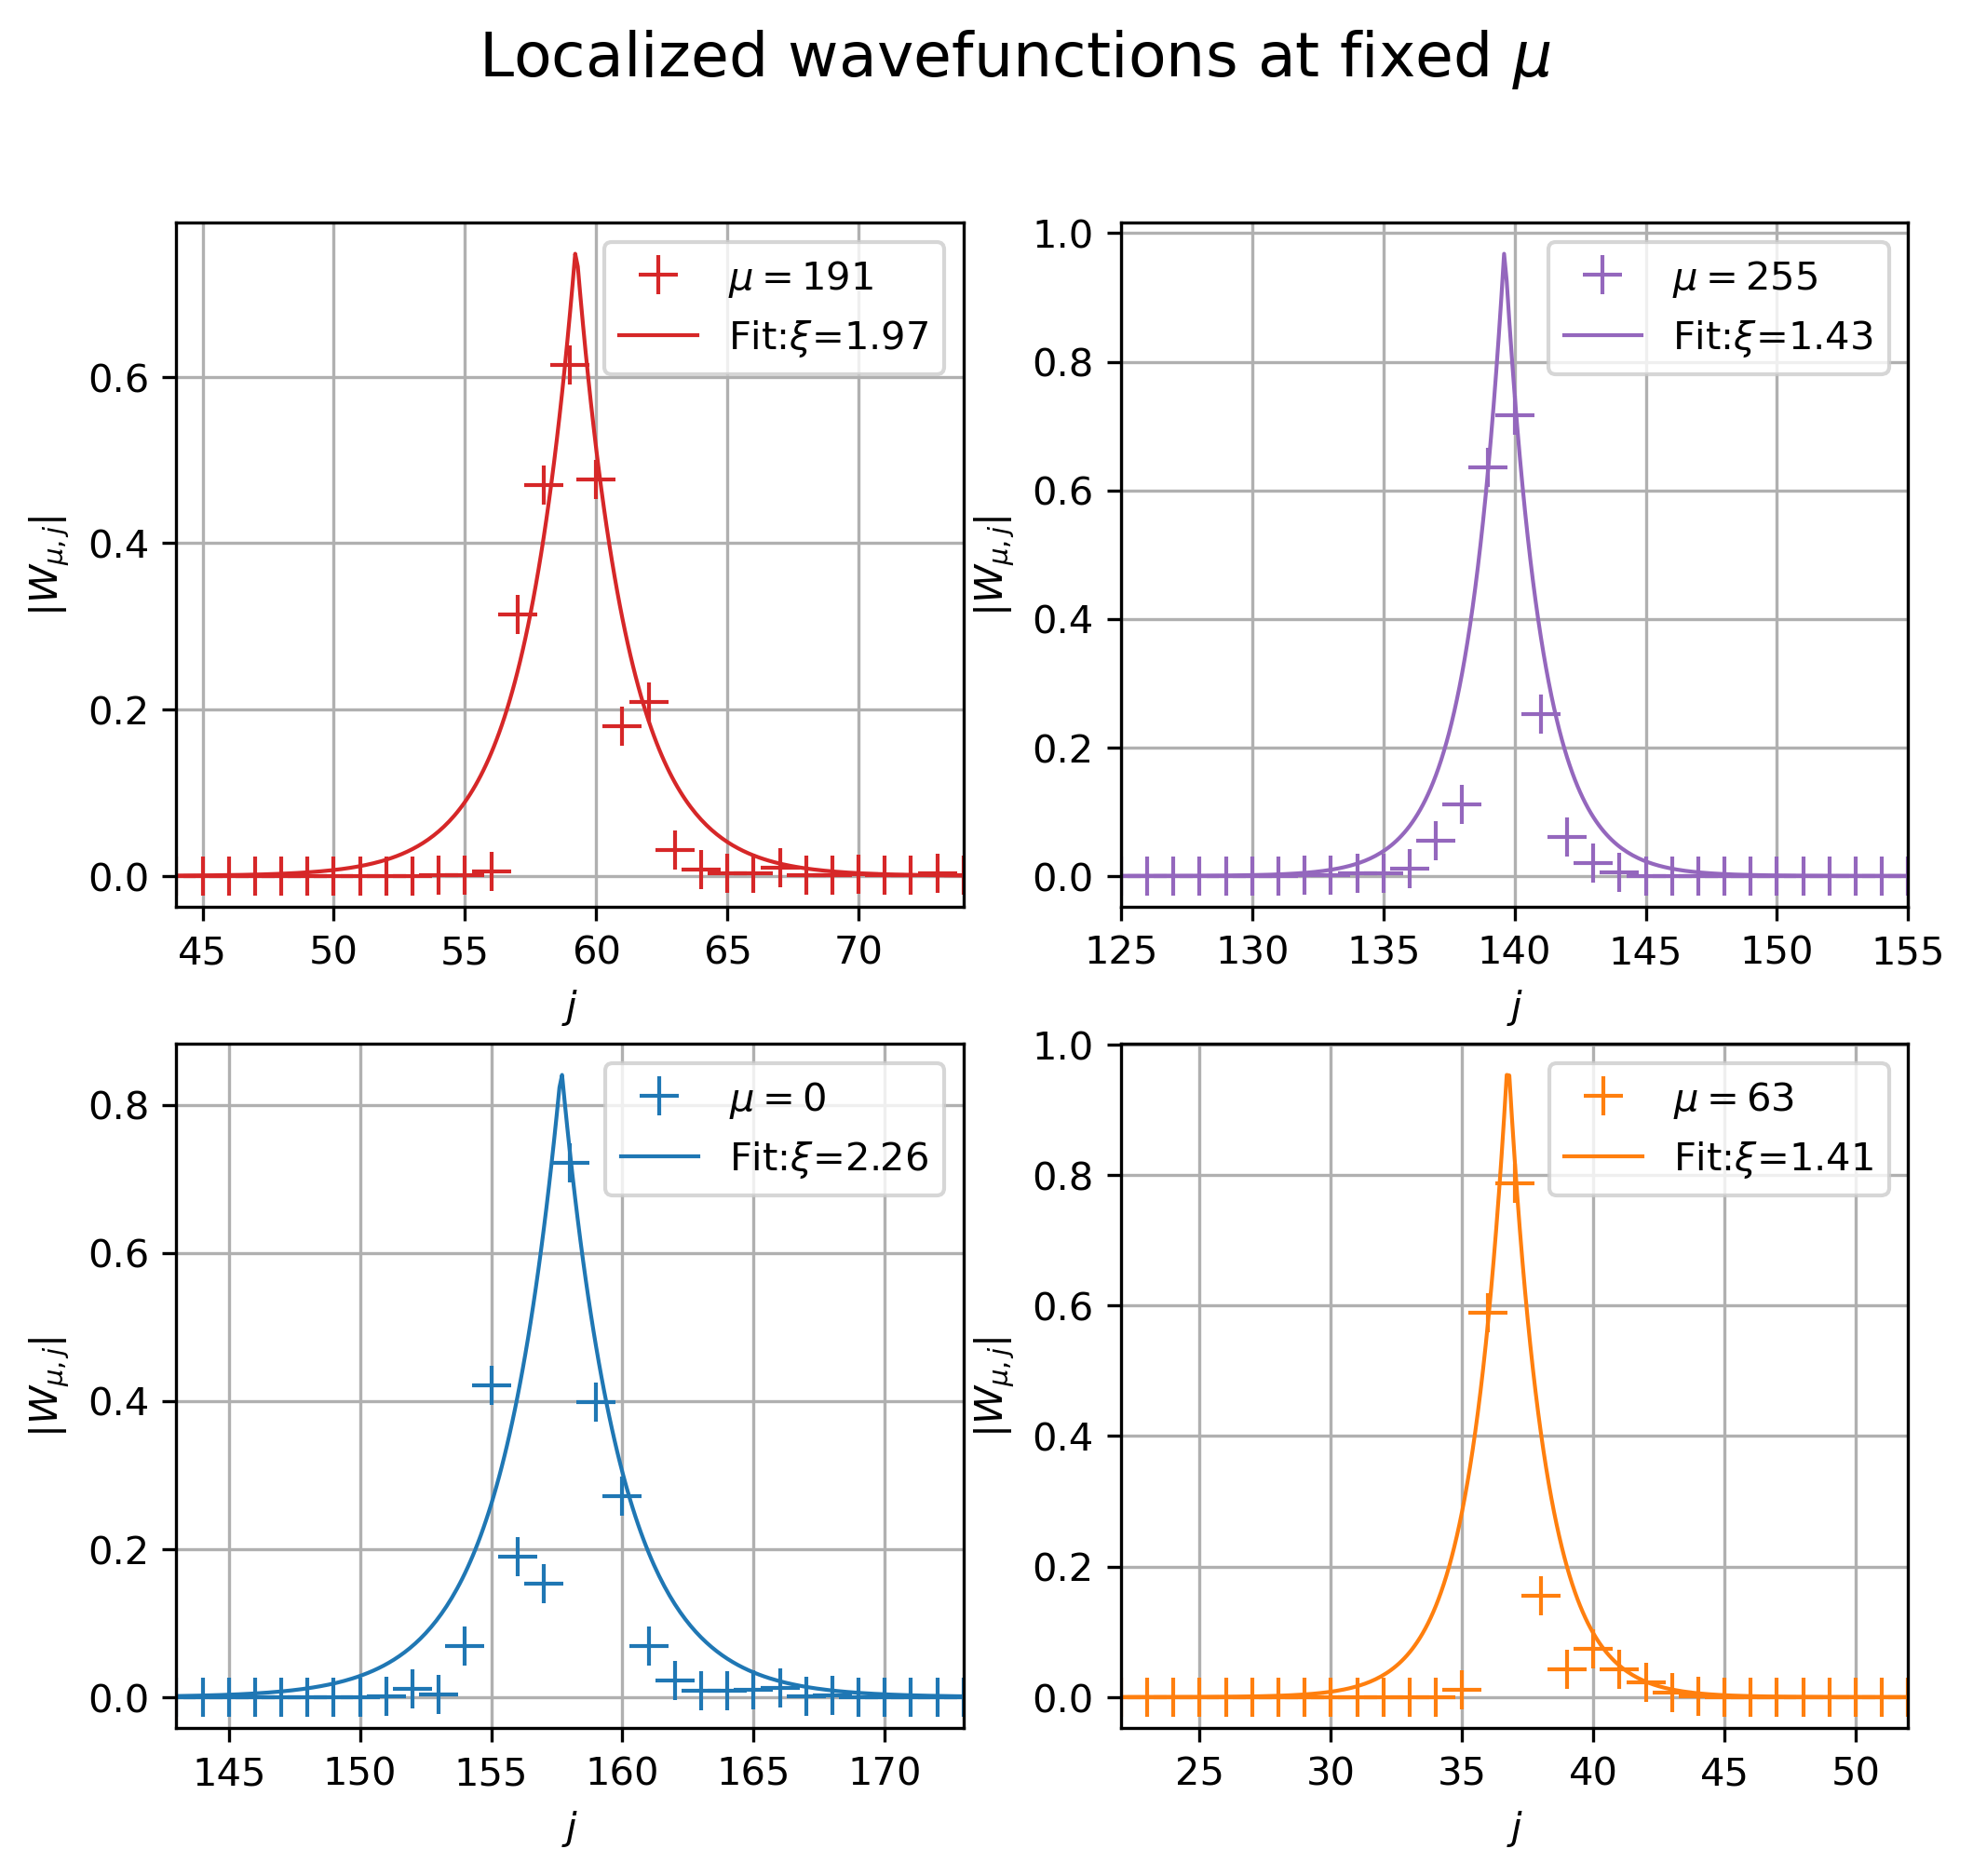

In [15]:
### Fit upper bound to find xi

mus = np.array([191, 255, 0, 63])
c = ["C3", "C4", "C0", "C1"]


import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 7), dpi=300)
plt.suptitle(r"Localized wavefunctions at fixed $\mu$", fontsize=16)
for i,mu in enumerate(mus):
    #Fit
    par = fit_upper_bound(L_, nW[:,mu])

    # Plot
    loc = 221+i
    ax = plt.subplot(loc)
    plt.xlabel(r"$j$")
    plt.ylabel(r"$|W_{\mu,j}|$")
    plt.plot(np.arange(L_), nW[:,mu], "+", markersize=10, label=r"$\mu=${}".format(mu), color=c[i])
    plt.plot(np.arange(0, L_, 0.1), bound(np.arange(0, L_, 0.1), *par), "-", linewidth=1, label=r"Fit:$\xi$={}".format(np.round(par[1], 2)), color=c[i])
    xmax = np.argwhere(np.max(nW[:,mu])==nW[:,mu])
    plt.xlim(xmax-15, xmax+15)
    plt.grid()
    plt.legend(loc = "upper right")

plt.show()

#### 3.2) IPR in thermodynamic limit

**N.B.**: Next cells are commented to avoid running 3 hour long computations again. The results have already been stored in some .npy files saved in this folders, and they're loaded when plotting. Uncomment and run the cells **at your risk**.

In [16]:
### IPR averaged over disorder and mu, for L variable: J=0.0, h=1.0

# Ls = np.concatenate((np.arange(5, 140, 5), np.arange(140, 280, 20), np.arange(280, 520, 40), np.array([1000, 1500, 2000])))
# Ndis = 200
# x = 0 #anisotropy
# PBC = True
# p = 1

# # Random stuff
# np.random.seed(42)

# IPR = np.zeros((len(Ls), Ndis))
# for j,L_ in enumerate(Ls):
#     print(L_)

#     # Define couplings
#     Jmin = 0.
#     hmax = 1.
#     h = np.random.uniform(0, hmax, (Ndis, L_))
#     J = np.random.uniform(Jmin, 1, (Ndis, L_))

#     for i in range(Ndis):

#         # Diagonalization
#         _, U = diagonalize(L_, (J[i], h[i], x), PBC, p)

#         # Define W, |W| IPR
#         W = U[:,:L_] # W_j,mu
#         nW = np.sqrt( np.power(W[:L_], 2) + np.power(W[L_:], 2) ) # |W_j,mu|
#         IPR[j,i] = np.mean(np.sum(np.power(nW, 4), axis=0)) # IPR

# avIPR0 = np.mean(IPR, axis=1)
   

In [17]:
### IPR averaged over disorder and mu, for L variable: J=0.8, h=0.2

# Ls = np.concatenate((np.arange(5, 140, 5), np.arange(140, 280, 20), np.arange(280, 520, 40), np.array([1000, 1500, 2000])))
# Ndis = 200
# x = 0 #anisotropy
# PBC = True
# p = 1

# # Random stuff
# np.random.seed(42)

# IPR = np.zeros((len(Ls), Ndis))
# for j,L_ in enumerate(Ls):
#     print(L_)

#     # Define couplings
#     Jmin = 0.8
#     hmax = 0.2
#     h = np.random.uniform(0, hmax, (Ndis, L_))
#     J = np.random.uniform(Jmin, 1, (Ndis, L_))

#     for i in range(Ndis):

#         # Diagonalization
#         _, U = diagonalize(L_, (J[i], h[i], x), PBC, p)

#         # Define W, |W| IPR
#         W = U[:,:L_] # W_j,mu
#         nW = np.sqrt( np.power(W[:L_], 2) + np.power(W[L_:], 2) ) # |W_j,mu|
#         IPR[j,i] = np.mean(np.sum(np.power(nW, 4), axis=0)) # IPR

# avIPR1 = np.mean(IPR, axis=1)
   

In [18]:
### IPR averaged over disorder and mu, for L variable: J=0.5, h=0.5

# Ls = np.concatenate((np.arange(5, 140, 5), np.arange(140, 280, 20), np.arange(280, 520, 40), np.array([1000, 1500, 2000])))
# Ndis = 200
# x = 0 #anisotropy
# PBC = True
# p = 1

# # Random stuff
# np.random.seed(42)

# IPR = np.zeros((len(Ls), Ndis))
# for j,L_ in enumerate(Ls):
#     print(L_)

#     # Define couplings
#     Jmin = 0.5
#     hmax = 0.5
#     h = np.random.uniform(0, hmax, (Ndis, L_))
#     J = np.random.uniform(Jmin, 1, (Ndis, L_))

#     for i in range(Ndis):

#         # Diagonalization
#         _, U = diagonalize(L_, (J[i], h[i], x), PBC, p)

#         # Define W, |W| IPR
#         W = U[:,:L_] # W_j,mu
#         nW = np.sqrt( np.power(W[:L_], 2) + np.power(W[L_:], 2) ) # |W_j,mu|
#         IPR[j,i] = np.mean(np.sum(np.power(nW, 4), axis=0)) # IPR

# avIPR2 = np.mean(IPR, axis=1)
   

In [19]:
### Dump data to file 

# np.save("J00h01", avIPR0)
# np.save("J08h02", avIPR1)
# np.save("J05h05", avIPR2)

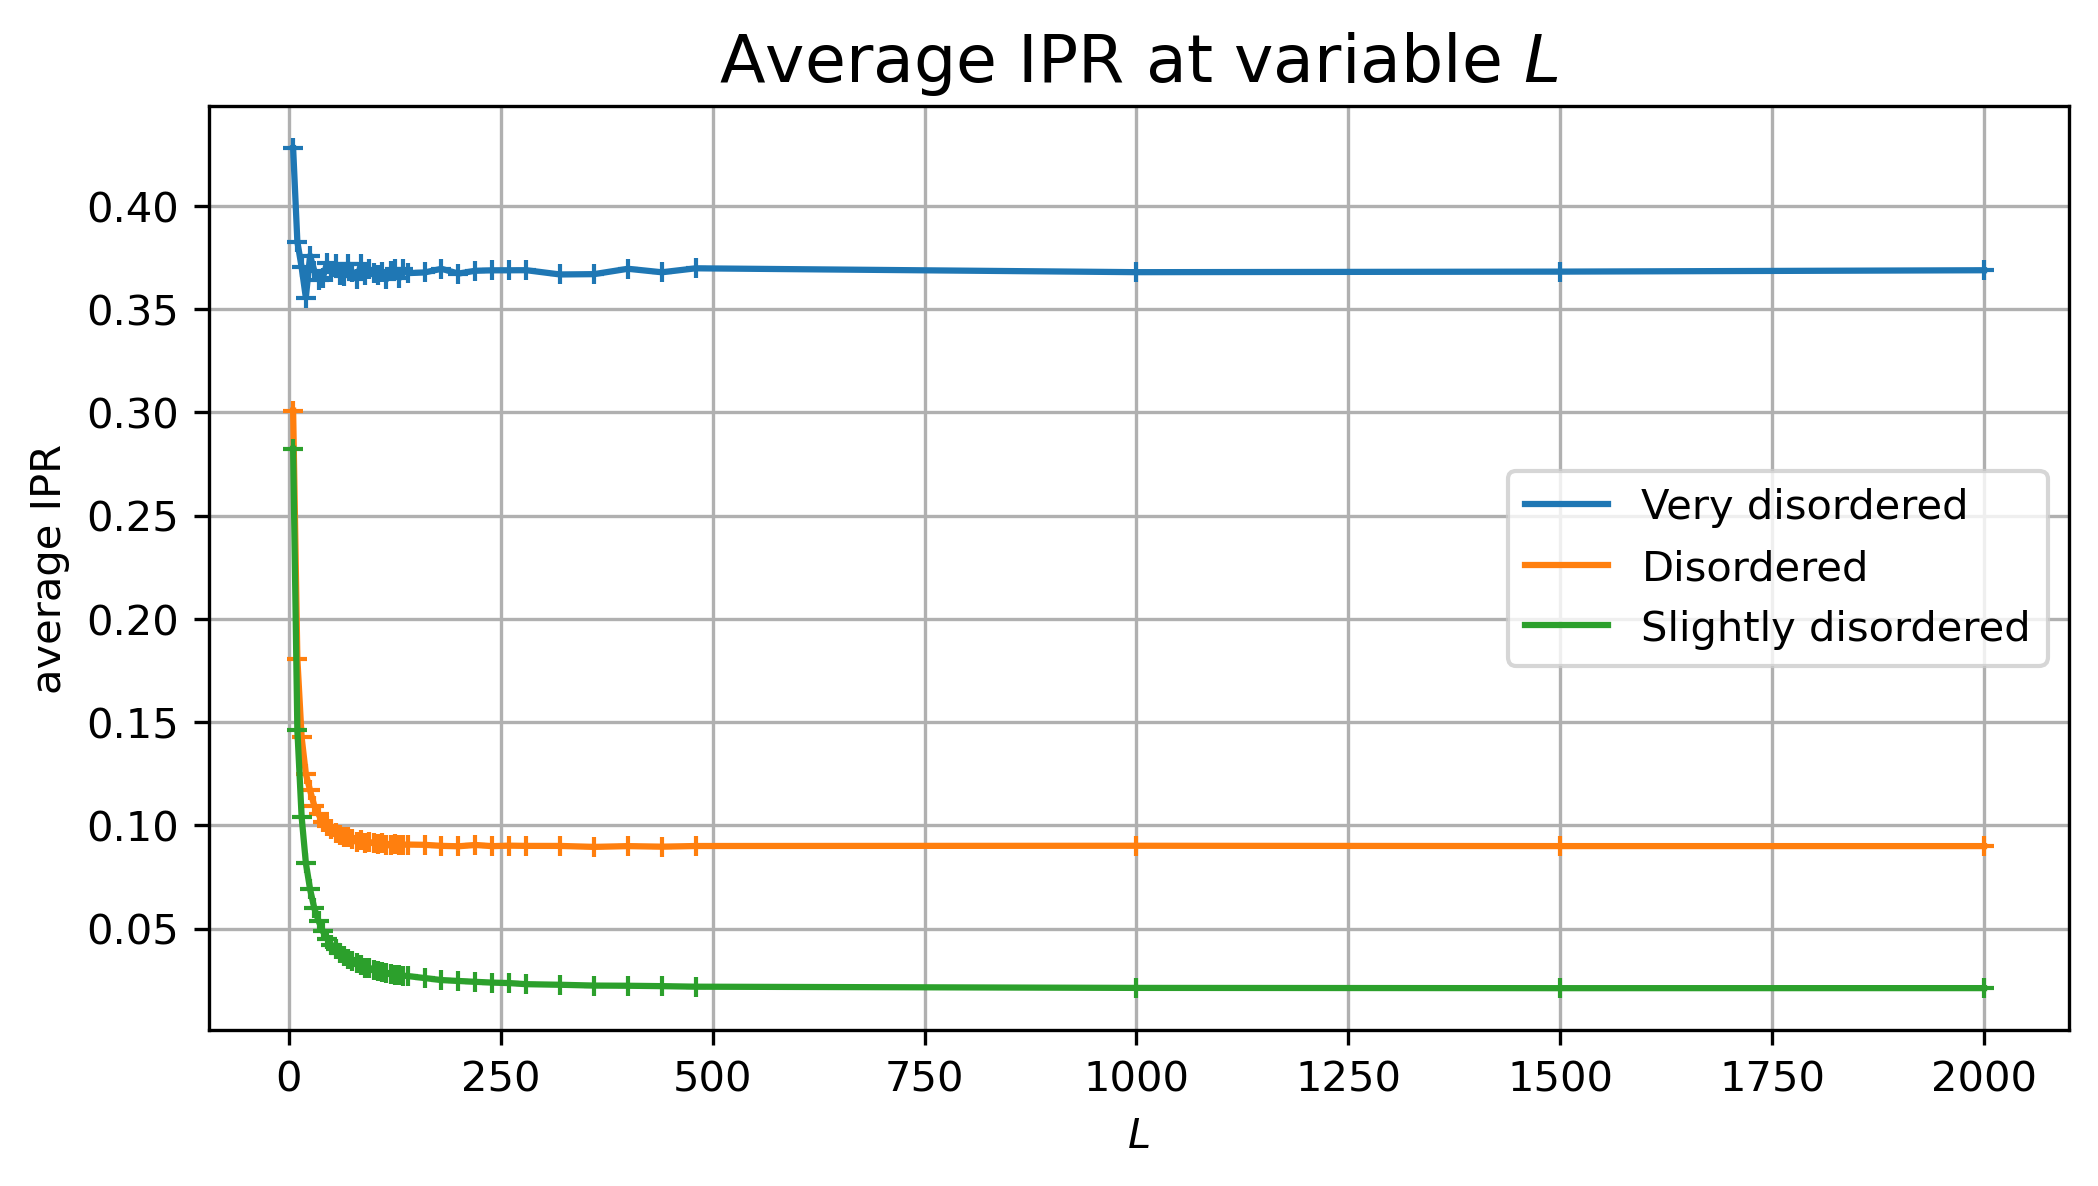

In [20]:
### Plot averaged IPR

Ls = np.concatenate((np.arange(5, 140, 5), np.arange(140, 280, 20), np.arange(280, 520, 40), np.array([1000, 1500, 2000])))

# Load data from file
J00h01 = np.load("J00h01.npy")
J08h02 = np.load("J08h02.npy")
J05h05 = np.load("J05h05.npy")

# Plot
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.set_title(r"Average IPR at variable $L$", fontsize=16)
plt.xlabel(r"$L$")
plt.ylabel(r"average IPR")

# 0, 1
plt.plot(Ls, J00h01, "-", linewidth=1.5, color="C0", label="Very disordered")
plt.plot(Ls, J00h01, "+", markersize=5, color="C0")

# 0.5, 0.5
plt.plot(Ls, J05h05, "-", linewidth=1.5, color="C1", label="Disordered")
plt.plot(Ls, J05h05, "+", markersize=5, color="C1")

# 0.8, 0.2
plt.plot(Ls, J08h02, "-", linewidth=1.5, color="C2", label="Slightly disordered")
plt.plot(Ls, J08h02, "+", markersize=5, color="C2")

plt.grid()
plt.legend()

plt.show()

# **4) Assignment**: Spin-spin correlation functions

#### 4.0) Propedeutic procedures: check of the routines

In [21]:
### Compute G and F from U and V

# Parameters
L = 256
x = 1
PBC = False
p = 1
# J = 1
# h = 0.5

# Random stuff
np.random.seed(4269)

# Define couplings
Jmin = 0.
hmax = 1.
J = np.random.uniform(Jmin, 1, L)
h = np.random.uniform(0, hmax, L)

# Diagonalization
_, UU = diagonalize(L, (J, h, x), PBC, p)
U = UU[:L, :L]
V = UU[L:, :L]

G, F = compute_GF(U, V)

# Checking symmetry
print("Checking symmetry of G ...")
check = G-G.T
if np.any(check>1e-8):
    print("\tG is NOT symmetric")
else:
    print("\tG is symmetric")

print()

print("Checking antisymmetry of F ...")
check = F+F.T
if np.any(check>1e-8):
    print("\tF is NOT antisymmetric")
else:
    print("\tF is antisymmetric")

# Compute M
M = compute_M(U, V)

Checking symmetry of G ...
	G is symmetric

Checking antisymmetry of F ...
	F is antisymmetric


#### 4.1) 

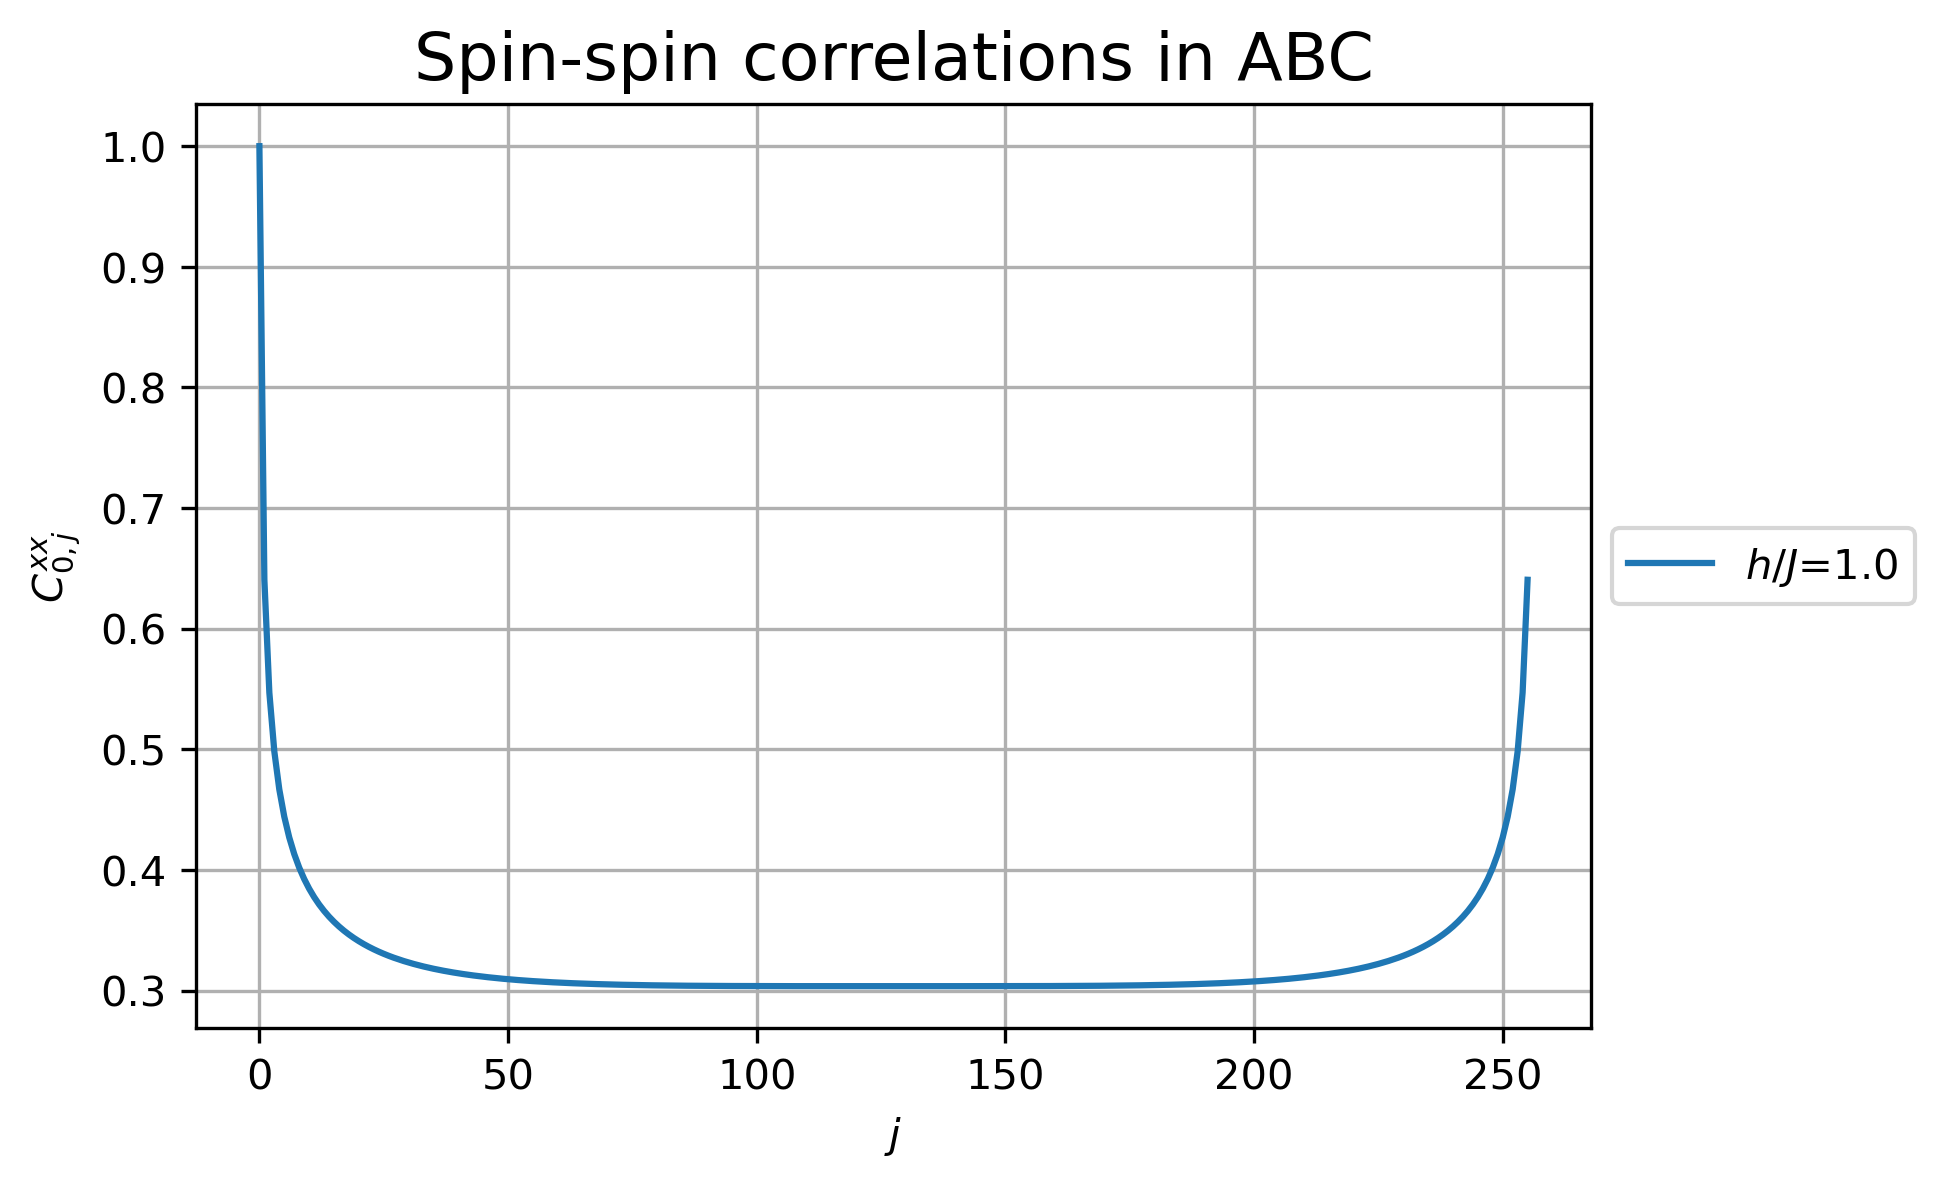

In [22]:
### Compute correlation function in ABC 

# Parameters
L = 256
x = 1
PBC = True
p = 1
J = 1
# hs = np.array([0.0, 0.5, 1.0, 1.5, 2.0])
hs = np.array([1.0])

corr = np.zeros((len(hs), int(L)))
j1 = 0 #Starting point of the correlation

# Compute correlation functions
for i,h in enumerate(hs):
    M = compute_M_frmsys(L, (J, h, x), PBC, p)
    for j2 in range(int(L)):
        corr[i,j2] = compute_corr(j1, j2, M)

# Plot
fig = plt.figure(figsize=(6, 4), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.set_title(r"Spin-spin correlations in ABC", fontsize=16)
plt.xlabel(r"$j$")
plt.ylabel(r"$C_{0, j}^{xx}$")
for i,h in enumerate(hs):
    plt.plot(np.arange(int(L)), corr[i], "-", linewidth=1.5, label=r"$h/J$={}".format(h/J))
plt.grid()

plt.legend(loc="center left", bbox_to_anchor = (1, .5))
plt.show()

#### 5.2) 

In [23]:
### Corr function for L variable

# Parameters
Ls = np.concatenate((np.arange(4, 20, 2), np.arange(20, 300, 10), np.arange(300, 1000, 100))) 
x = 1
PBC = True
p = 0
J = 1
hs = np.array([0.5, 1.0, 2.0])

j1 = 0 #Starting point of the correlation

# h = 0.5
corr_05 = np.zeros((len(Ls)))
corr_10 = np.zeros((len(Ls)))
corr_20 = np.zeros((len(Ls)))
for i,L in enumerate(Ls):
    j2 = int(L/2)
    # h = 0.5
    M = compute_M_frmsys(L, (J, hs[0], x), PBC, p)    
    corr_05[i] = compute_corr(j1, j2, M)
    # h = 1.0
    M = compute_M_frmsys(L, (J, hs[1], x), PBC, p)
    j2 = int(L/2)
    corr_10[i] = compute_corr(j1, j2, M)
    # h = 2.0
    M = compute_M_frmsys(L, (J, hs[2], x), PBC, p)
    j2 = int(L/2)
    corr_20[i] = compute_corr(j1, j2, M)

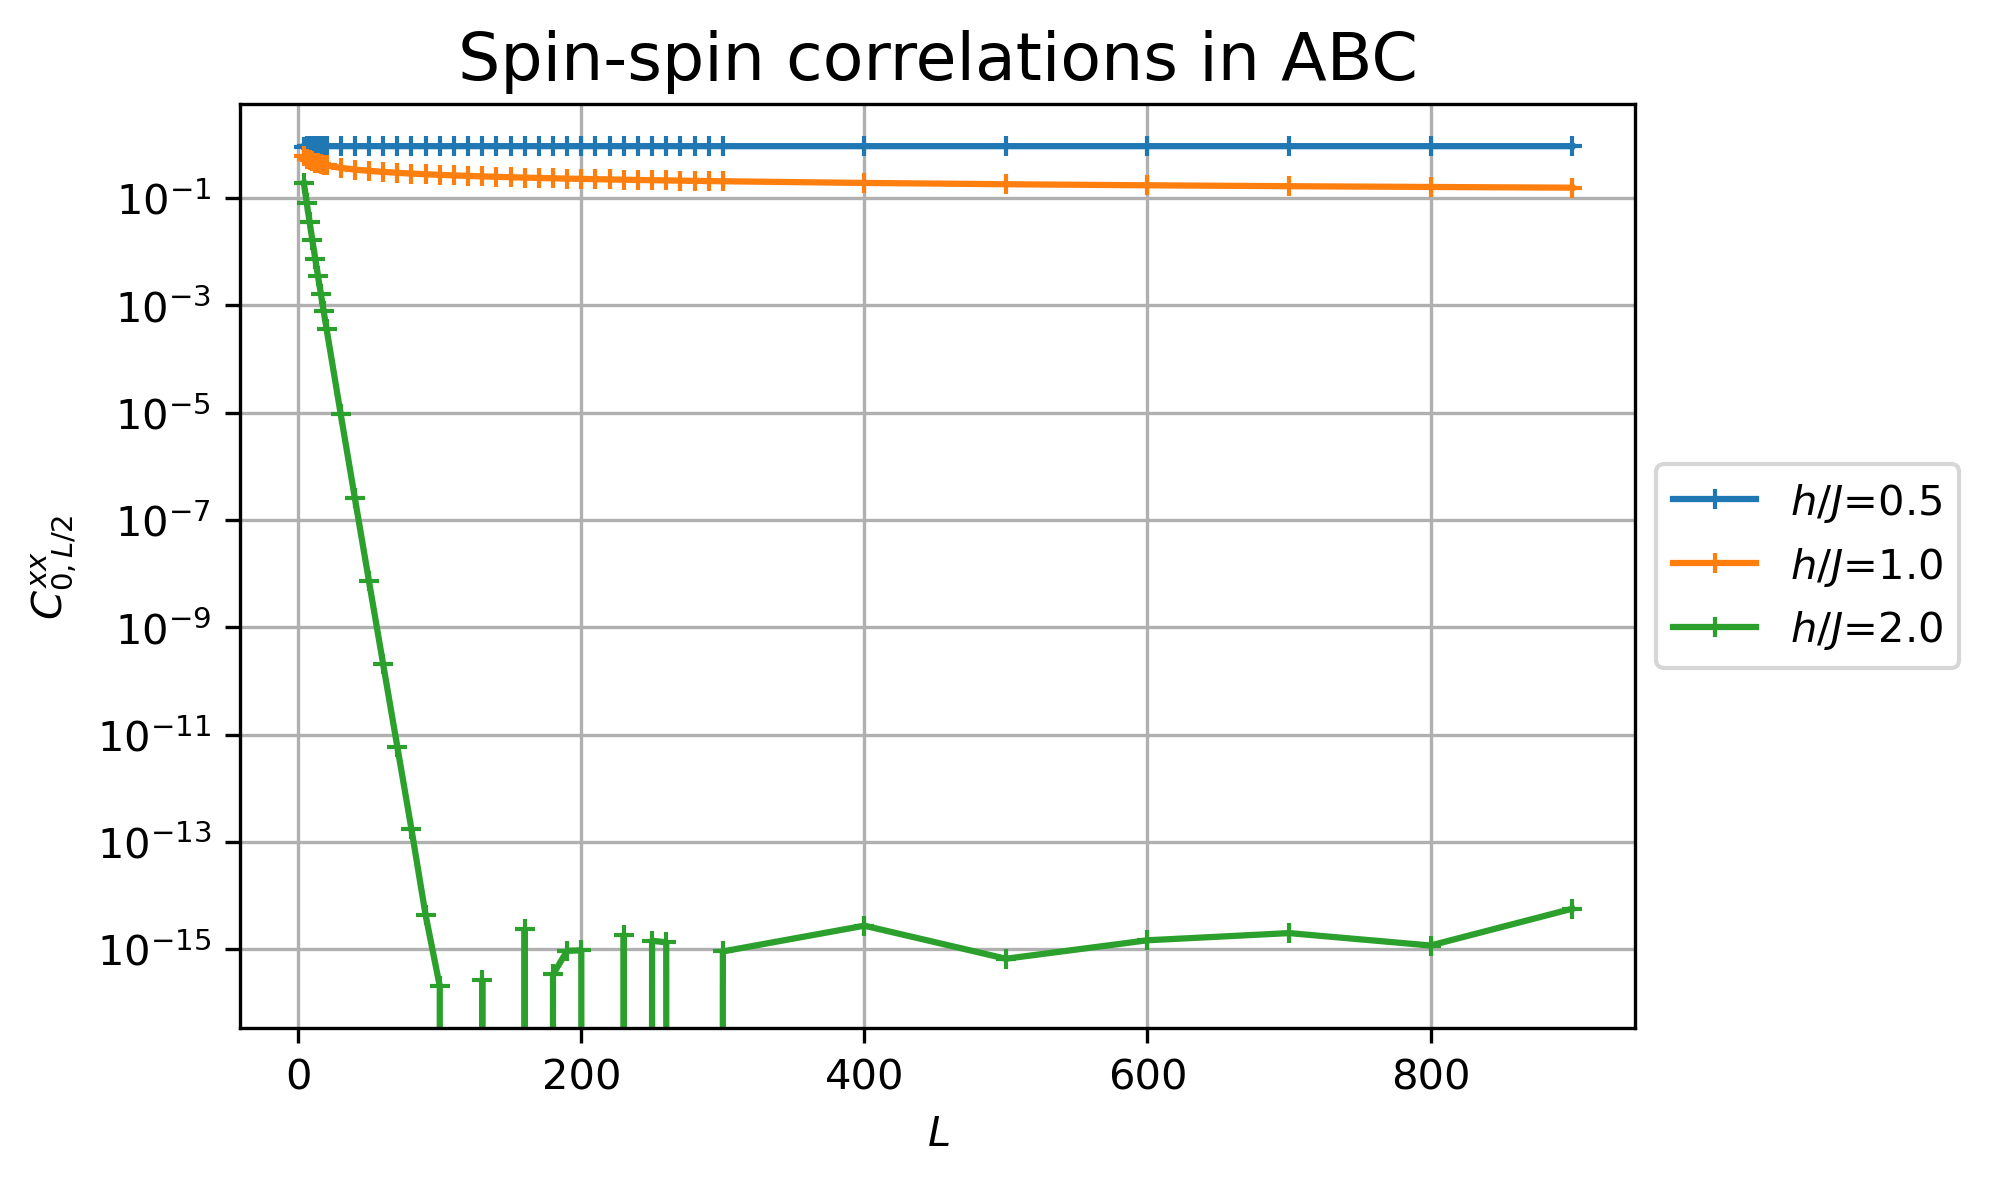

In [24]:
# Plot
fig = plt.figure(figsize=(6, 4), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.set_title(r"Spin-spin correlations in ABC", fontsize=16)
plt.xlabel(r"$L$")
plt.ylabel(r"$C_{0, L/2}^{xx}$")
plt.plot(Ls, corr_05, linestyle="-", marker="+", markersize="5", linewidth=1.5, label=r"$h/J$={}".format(hs[0]/J))
plt.plot(Ls, corr_10, linestyle="-", marker="+", markersize="5", linewidth=1.5, label=r"$h/J$={}".format(hs[1]/J))
plt.plot(Ls, corr_20, linestyle="-", marker="+", markersize="5", linewidth=1.5, label=r"$h/J$={}".format(hs[2]/J))
plt.yscale('log')
plt.grid()
plt.legend(loc="center left", bbox_to_anchor = (1, .5))
plt.show()

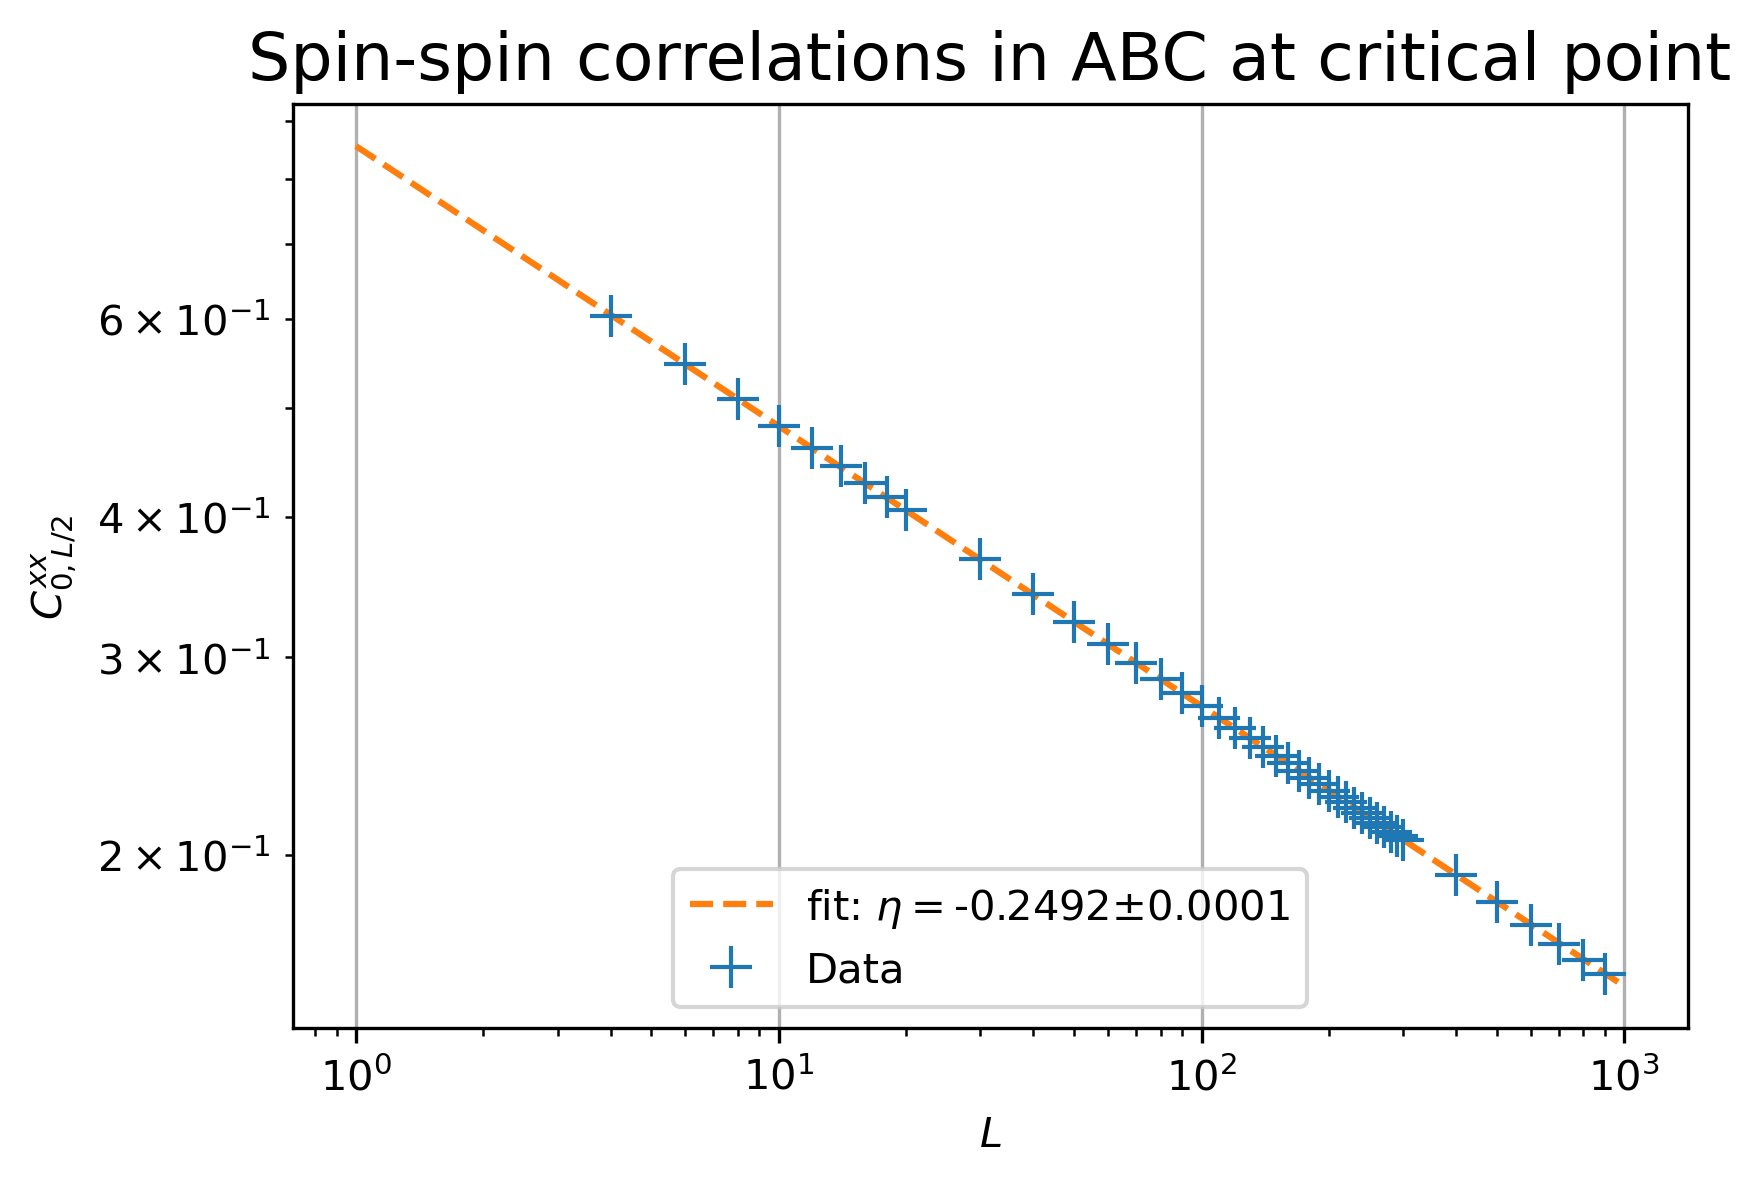

In [25]:
### Critical fit

def fit_critical(x_, C_, eta_):
    return C_*np.power(x_, eta_)

par, cov = sp.optimize.curve_fit(fit_critical, Ls, corr_10)

# Plot
xxx = np.arange(1, 1000, 1)
fig = plt.figure(figsize=(6, 4), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.set_title(r"Spin-spin correlations in ABC at critical point", fontsize=16)
plt.xlabel(r"$L$")
plt.ylabel(r"$C_{0, L/2}^{xx}$")
plt.plot(xxx, fit_critical(xxx, *par), linestyle="--", linewidth=1.5, label=r"fit: $\eta=${}$\pm${}".format(np.round(par[1], 4),
                                                                                                           np.round(np.sqrt(cov[1,1]), 4)), color="C1")
plt.plot(Ls, corr_10, "+", markersize="10", linewidth=1.5, label=r"Data", color="C0")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend(loc="lower center")
plt.show()

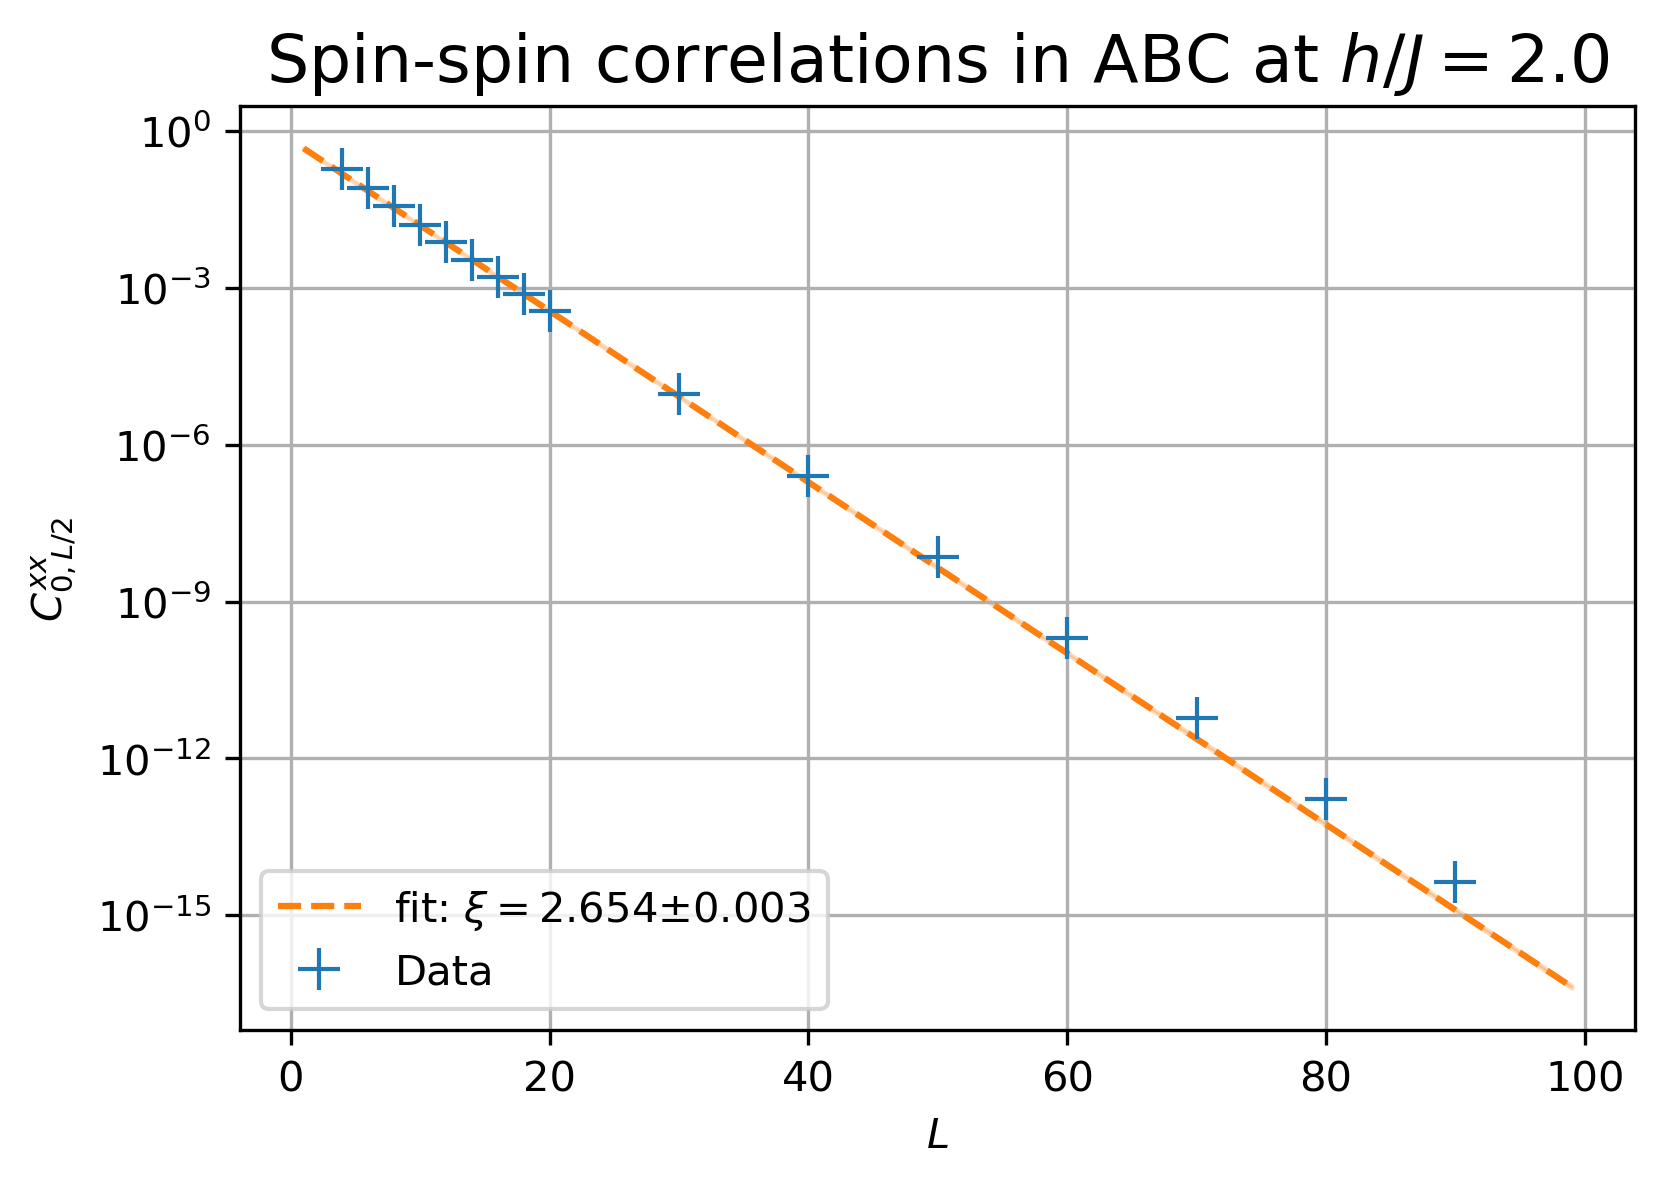

In [26]:
### Non-critical fit: h/J = 2.0

def fit_noncritical(x_, C_, xi_):
    return C_*np.exp( -x_/xi_)

Lmin = 5
Lmax = 16

par, cov = sp.optimize.curve_fit(fit_noncritical, Ls[Lmin:Lmax], corr_20[Lmin:Lmax])

# Plot
xxx = np.arange(1, Ls[Lmax], 1)
fig = plt.figure(figsize=(6, 4), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.set_title(r"Spin-spin correlations in ABC at $h/J=2.0$", fontsize=16)
plt.xlabel(r"$L$")
plt.ylabel(r"$C_{0, L/2}^{xx}$")
plt.plot(xxx, fit_noncritical(xxx, *par), linestyle="--", linewidth=1.5, 
         label=r"fit: $\xi=${}$\pm${}".format(np.round(par[1], 3),np.round(np.sqrt(cov[1,1]), 3)), color="C1")
plt.fill_between(xxx, 
                 fit_noncritical(xxx, par[0]-np.sqrt(cov[0,0]), par[1]-np.sqrt(cov[1,1])), 
                 fit_noncritical(xxx, par[0]+np.sqrt(cov[0,0]), par[1]+np.sqrt(cov[1,1])),
                 color="C1", alpha=0.3)
plt.plot(Ls[:Lmax], corr_20[:Lmax], "+", markersize="10", linewidth=1.5, label=r"Data", color="C0")

plt.yscale('log')
plt.grid()
plt.legend(loc="lower left")
plt.show()


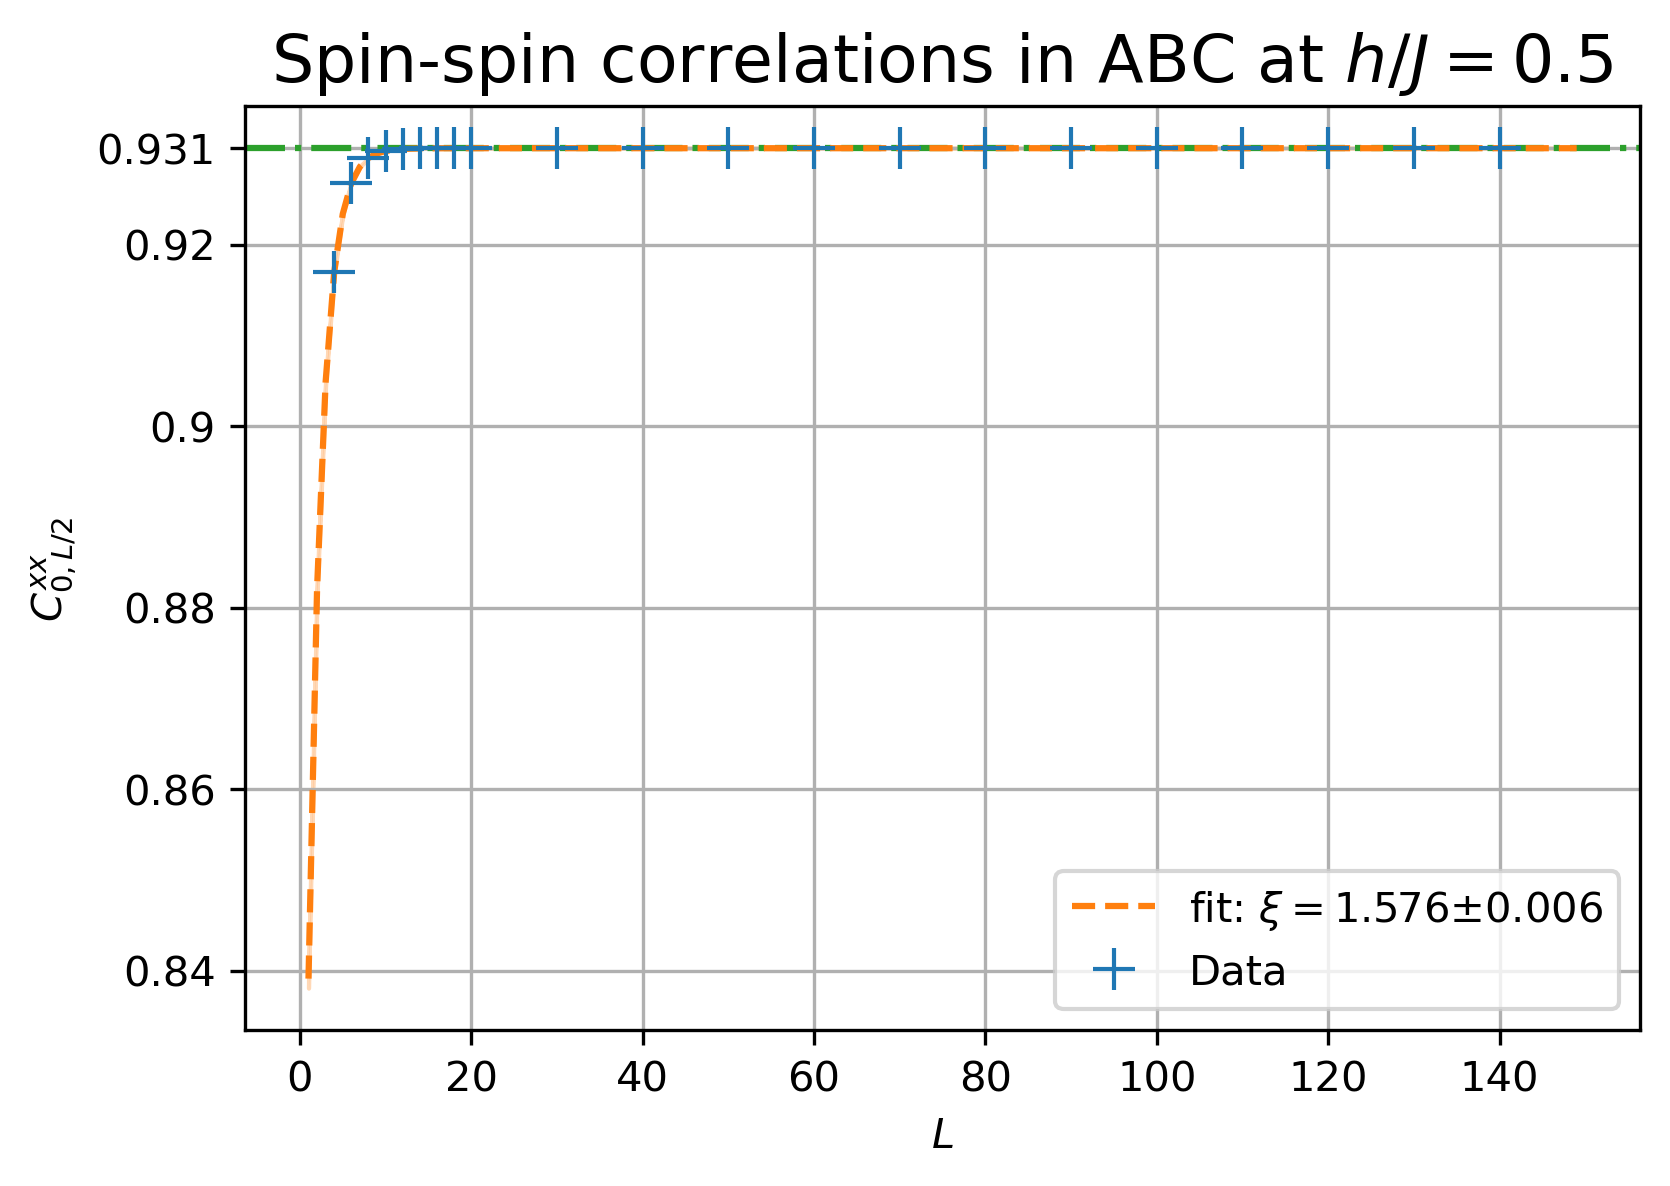

In [27]:
### Non-critical fit: h/J = 2.0

def fit_noncritical(x_, C_, xi_, k_):
    return -C_*np.exp( -x_/xi_) + k_

Lmin = 0
Lmax = 21

par, cov = sp.optimize.curve_fit(fit_noncritical, Ls[Lmin:Lmax], corr_05[Lmin:Lmax])

# Plot
xxx = np.arange(1, Ls[Lmax], 1)
fig = plt.figure(figsize=(6, 4), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.set_title(r"Spin-spin correlations in ABC at $h/J=0.5$", fontsize=16)
plt.xlabel(r"$L$")
plt.ylabel(r"$C_{0, L/2}^{xx}$")
ax.set_yticks(ticks=np.concatenate((np.arange(0.84, 0.94, 0.02),[par[2]])))
ax.set_yticklabels(np.concatenate((np.arange(0.84, 0.94, 0.02),[np.round(par[2], 3)])))
plt.axhline(par[2], color="C2", linestyle="-.")
plt.plot(xxx, fit_noncritical(xxx, *par), linestyle="--", linewidth=1.5, color="C1",
         label=r"fit: $\xi=${}$\pm${}".format(np.round(par[1], 3), np.round(np.sqrt(cov[1,1]), 3)))
plt.fill_between(xxx, 
                 fit_noncritical(xxx, par[0]-np.sqrt(cov[0,0]), par[1]-np.sqrt(cov[1,1]), par[2]-np.sqrt(cov[2,2])), 
                 fit_noncritical(xxx, par[0]+np.sqrt(cov[0,0]), par[1]+np.sqrt(cov[1,1]), par[2]+np.sqrt(cov[2,2])),
                 color="C1", alpha=0.3)
plt.plot(Ls[:Lmax], corr_05[:Lmax], "+", markersize="10", linewidth=1.5, label=r"Data", color="C0")

plt.grid()
plt.legend(loc="lower right")
plt.show()


# **5) Assignment**: Entanglement entropy

#### 5.0) Check routines

In [28]:
### Check lambdas

# Parameters
L = 64
l = 32
x = 1
PBC = True
p = 0
J = 1
h = 1.0

# Compute lambdas
lmbd = compute_lambda_frmsys(L, (J, h, x), PBC, p, l)
print(lmbd)

[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -0.99999999
 -0.9999999  -0.99999829 -0.99997553 -0.99970217 -0.996952   -0.97458515
 -0.84114302 -0.37159499  0.37159499  0.84114302  0.97458515  0.996952
  0.99970217  0.99997553  0.99999829  0.9999999   0.99999999  1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.        ]


#### 5.1)

In [8]:
### Entropy for L variable

# Parameters
Ls = np.concatenate((np.arange(4, 30, 2), np.arange(30, 300, 10), np.arange(300, 700, 20))) 
x = 1
PBC = False
p = 0
J = 1
hs = np.array([0.5, 1.0, 2.0])

entr_05 = np.zeros((len(Ls)))
entr_10 = np.zeros((len(Ls)))
entr_20 = np.zeros((len(Ls)))
for i,L in enumerate(Ls):
    l = int(L/2)
    # h = 0.5    
    lmbd = compute_lambda_frmsys(L, (J, hs[0], x), PBC, p, l)
    entr_05[i] = entropy(lmbd)
    # h = 1.0
    lmbd = compute_lambda_frmsys(L, (J, hs[1], x), PBC, p, l)
    entr_10[i] = entropy(lmbd)
    # h = 2.0
    lmbd = compute_lambda_frmsys(L, (J, hs[2], x), PBC, p, l)
    entr_20[i] = entropy(lmbd)

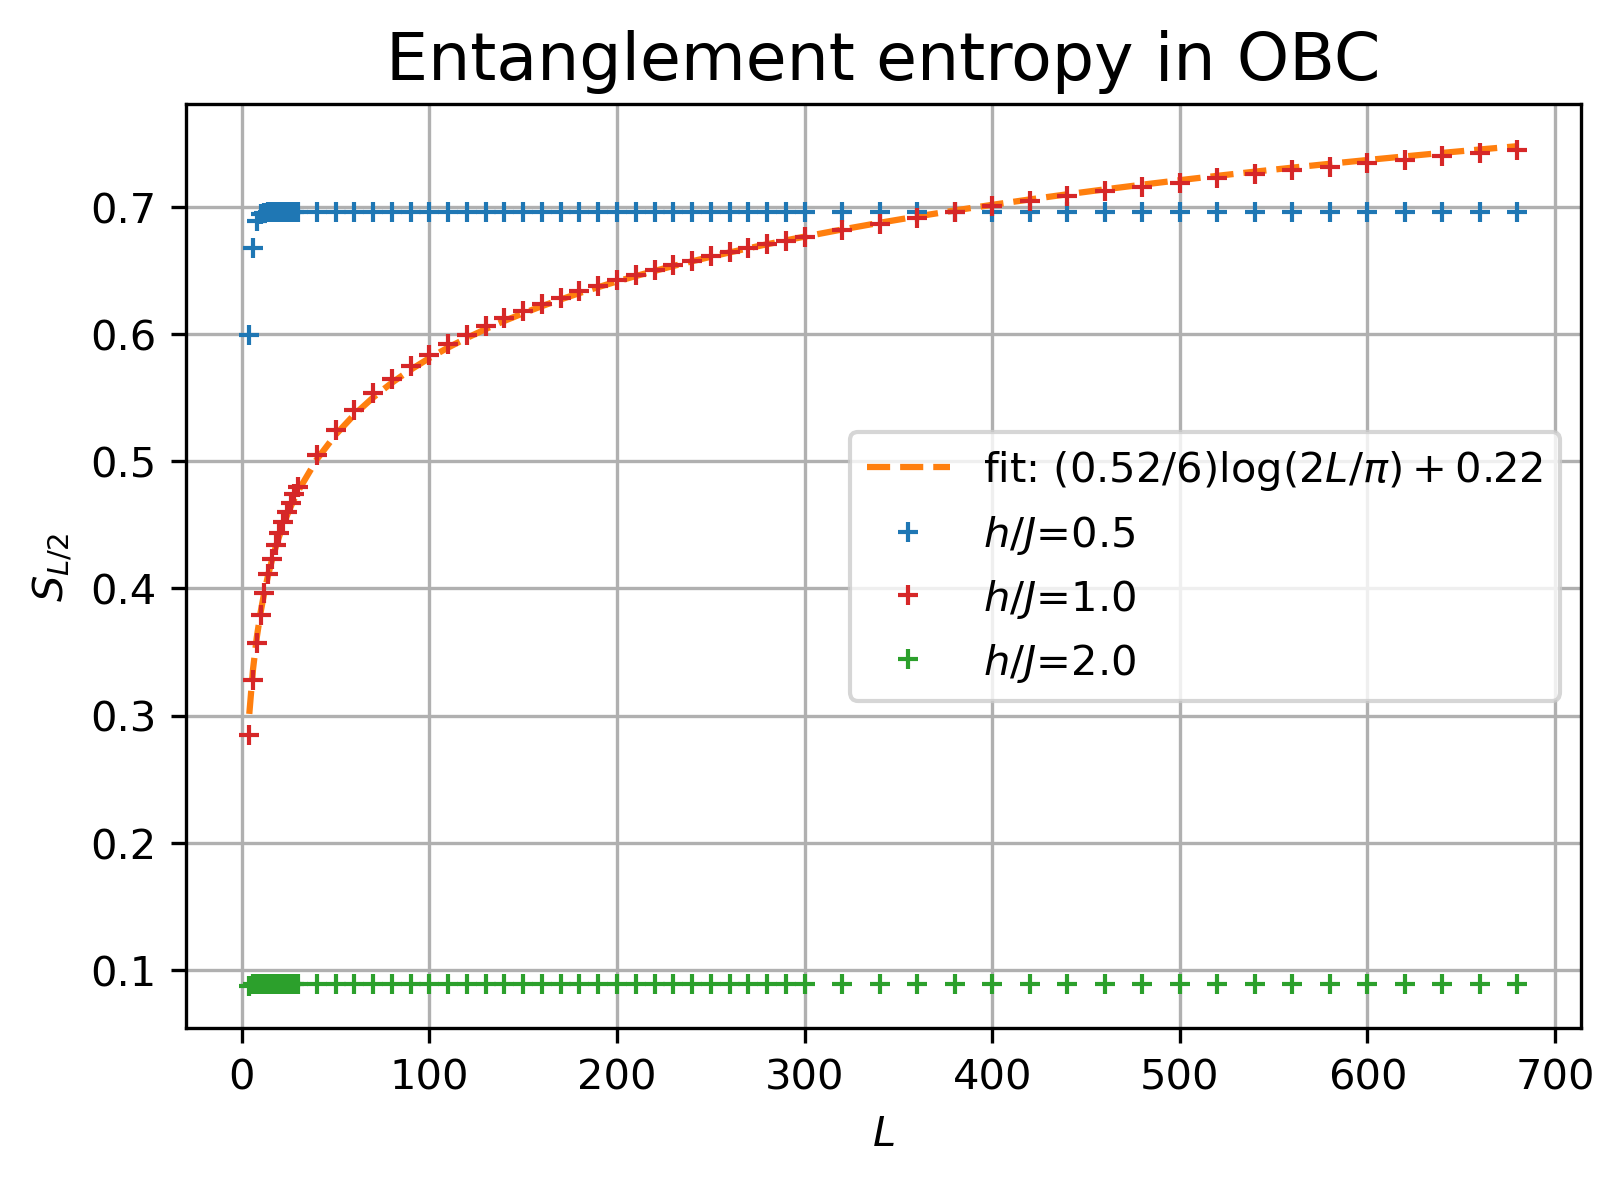

In [10]:
### Fit
def logfit(x_, A_, B_):
    return (A_/6.)*np.log(2*x_/np.pi) + B_

par, cov = sp.optimize.curve_fit(logfit, Ls, entr_10)

# Plot
fig = plt.figure(figsize=(6, 4), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.set_title(r"Entanglement entropy in OBC", fontsize=16)
plt.xlabel(r"$L$")
plt.ylabel(r"$S_{L/2}$")
plt.plot(Ls, logfit(Ls, *par), linestyle="--", linewidth=1.5, color="C1",
         label="fit: $(${}/6$)$log$(2L/\pi)+${}".format(np.round(par[0], 2), np.round(par[1], 3)))
plt.plot(Ls, entr_05, "+", markersize="5", label=r"$h/J$={}".format(hs[0]/J), color="C0")
plt.plot(Ls, entr_10, "+", markersize="5", label=r"$h/J$={}".format(hs[1]/J), color="C3")
plt.plot(Ls, entr_20, "+", markersize="5", label=r"$h/J$={}".format(hs[2]/J), color="C2")
plt.grid()
plt.legend(loc="center right")
plt.show()

#### 5.2) Comparison with CFT results: OBC

We fit this case with:
$$S(l,L)_\text{OBC} = \frac{c}{6}\log{\left(\frac{2L}{\pi}\sin{\frac{\pi l}{L}}\right)} +k $$
from _"Entanglement Entropy and Conformal Field Theory", Calabrese P. and Cardy J., 2009._

In [31]:
### Simulation

# L = 1000
# PBC = False
# p = 0
# J = 1

# ls = np.arange(L)

# h_ising = 1.
# x_ising = 1

# h_XX = 0.
# x_XX = 0

# entr_ising = np.zeros((len(ls)))
# entr_XX = np.zeros((len(ls)))
# for i,l in tqdm(enumerate(ls)):
#     # h = 0.5    
#     lmbd = compute_lambda_frmsys(L, (J, h_ising, x_ising), PBC, p, l)
#     entr_ising[i] = entropy(lmbd)
#     # h = 1.0
#     lmbd = compute_lambda_frmsys(L, (J, h_XX, x_XX), PBC, p, l)
#     entr_XX[i] = entropy(lmbd)

In [32]:
### Dump data to file 

# np.save("entr_ising", entr_ising)
# np.save("entr_XX", entr_XX)

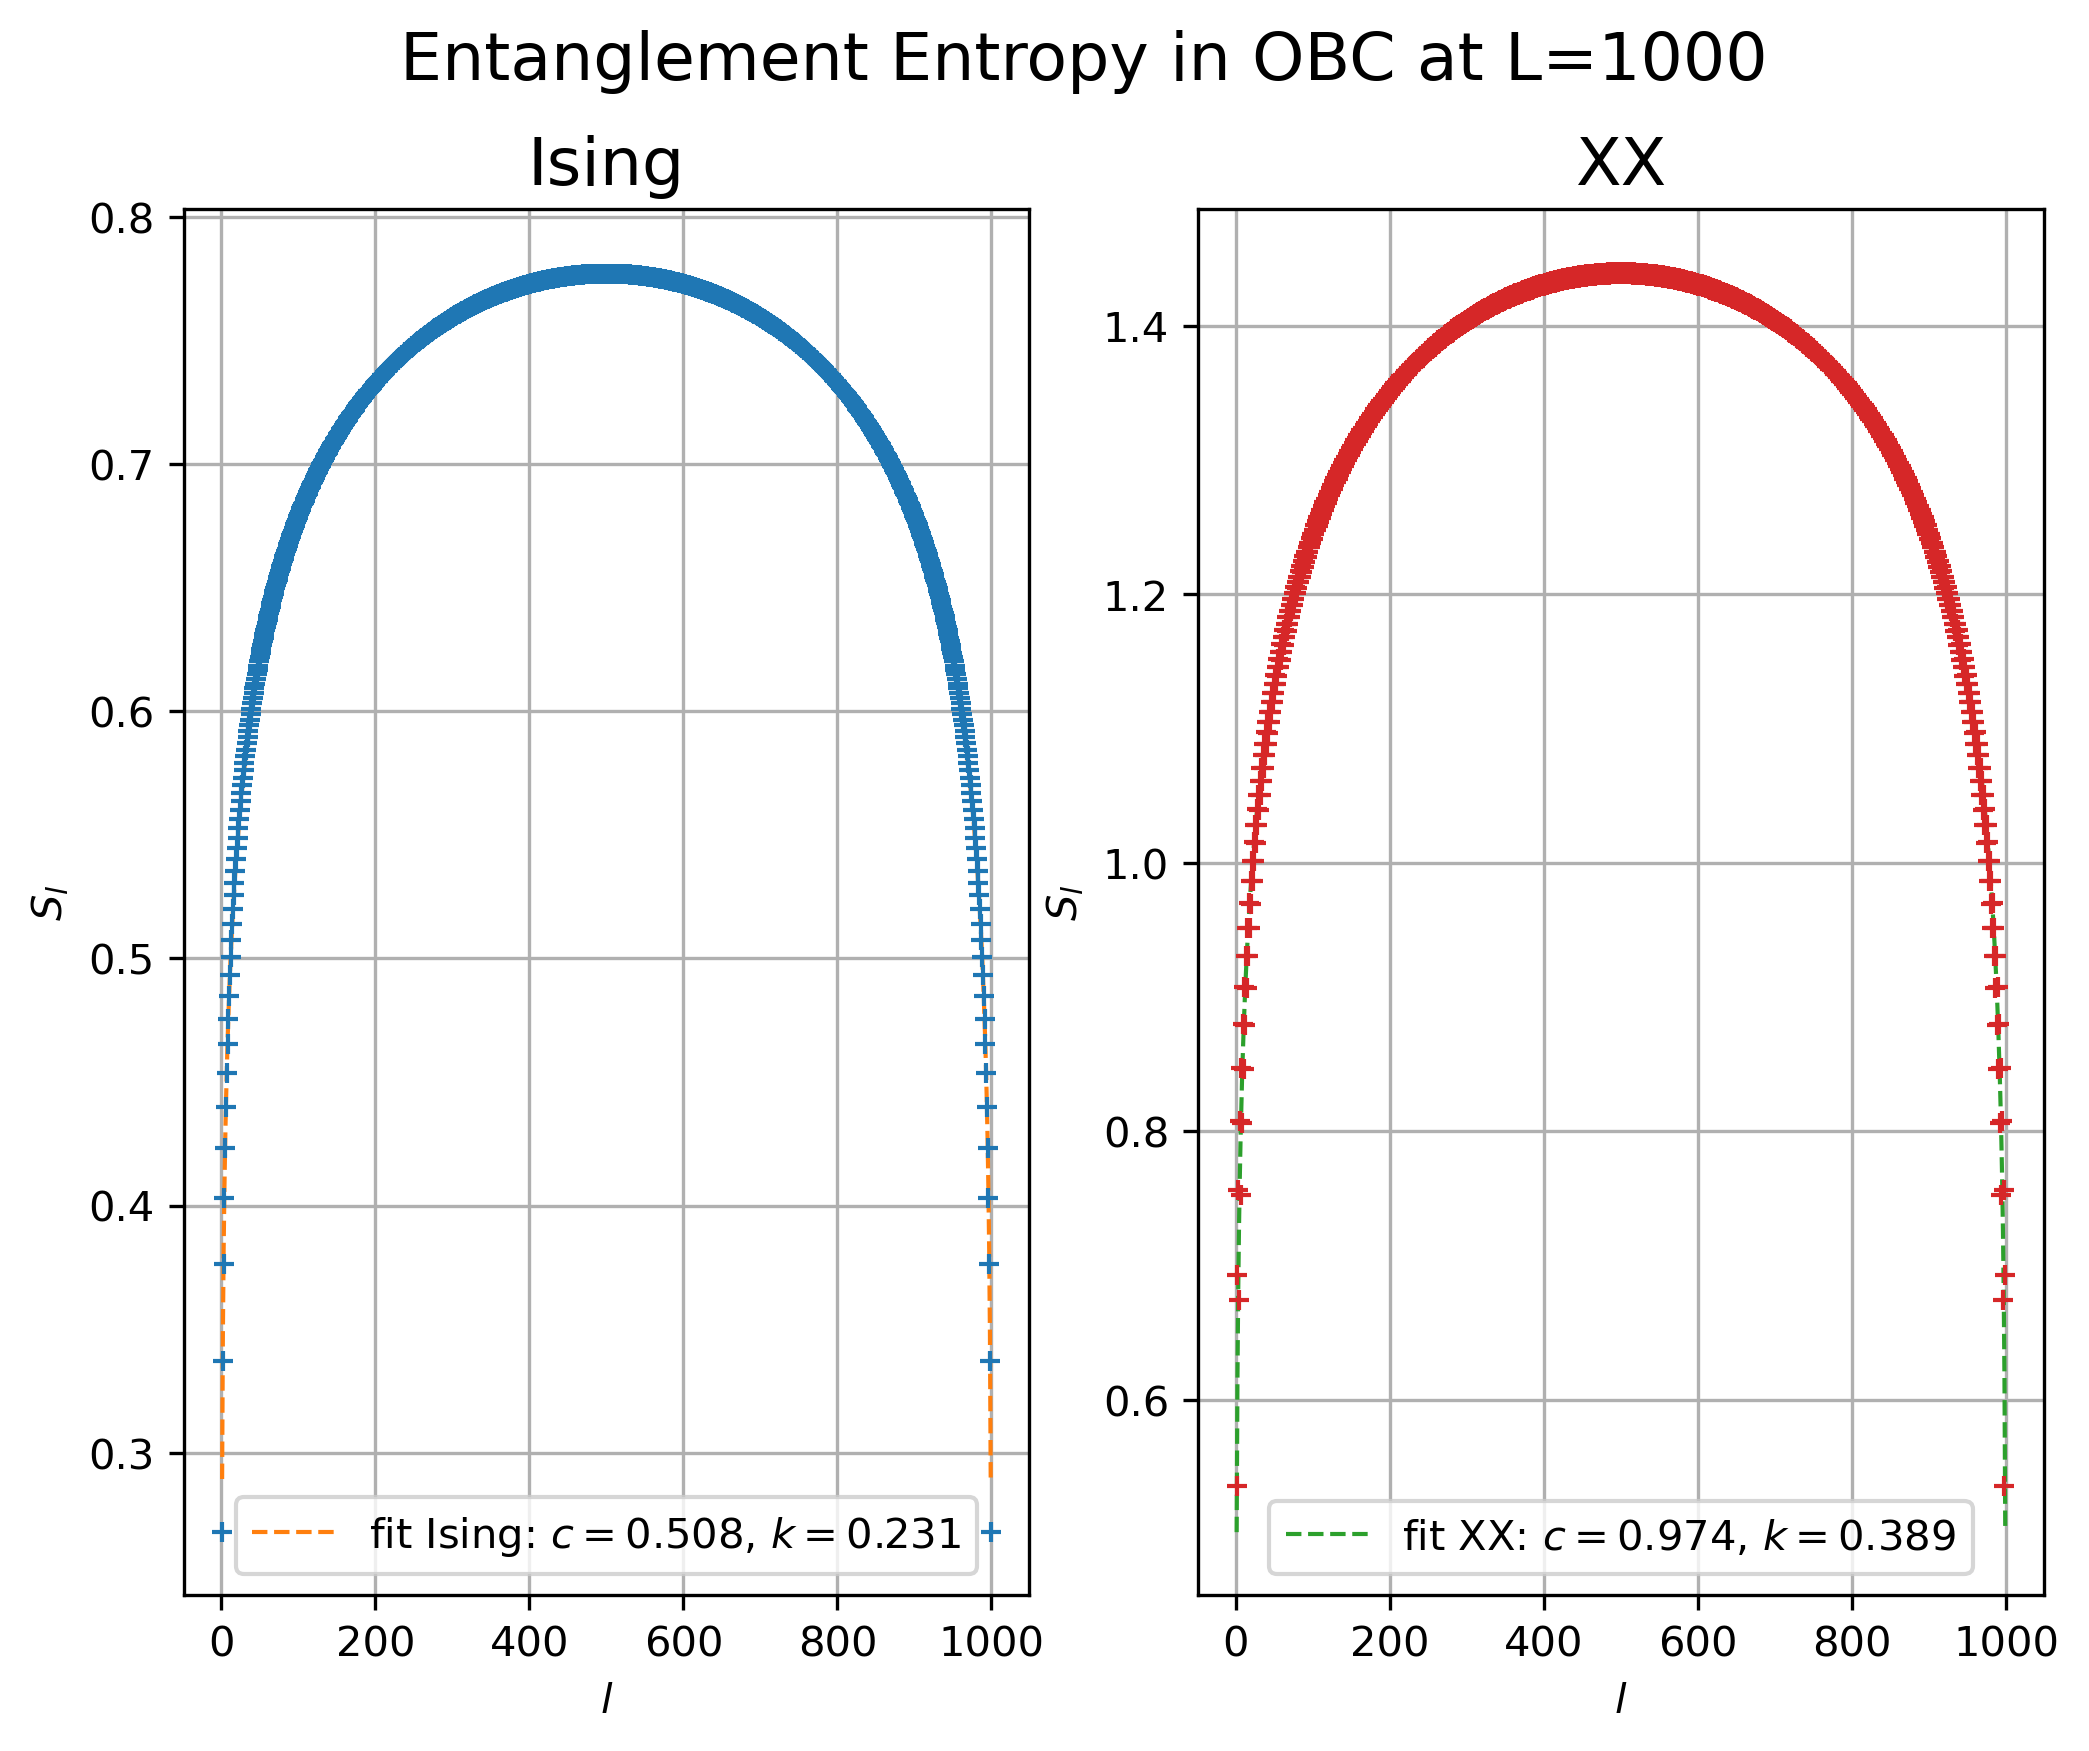

In [13]:
### Fit

entr_ising = np.load("entr_ising_OBC.npy")
entr_XX = np.load("entr_XX_OBC.npy")

L = 1000
ls = np.arange(L)

def CFT_general(x_, A_, B_, L_):
    return A_/6*np.log(2*L_/np.pi * np.sin(np.pi*x_/L_)) + B_

fit_CFT = lambda x, a, b : CFT_general(x, a, b, 1000)
l_min = 1

par_ising, cov_ising = sp.optimize.curve_fit(fit_CFT, ls[l_min:], entr_ising[l_min:])
par_XX, cov_XX = sp.optimize.curve_fit(fit_CFT, ls[l_min:], entr_XX[l_min:])

fig = plt.figure(figsize=(8, 6), dpi=300)
plt.suptitle(r"Entanglement Entropy in OBC at L={}".format(L), fontsize=16)

ax = plt.subplot(121)
ax.set_title(r"Ising", fontsize=16)
plt.xlabel(r"$l$")
plt.ylabel(r"$S_{l}$")
plt.plot(ls[l_min:], fit_CFT(ls[l_min:], *par_ising), linestyle="--", linewidth=1, color="C1",
         label="fit Ising: $c=${}, $k=${}".format(np.round(par_ising[0], 3), np.round(par_ising[1], 3)))
plt.plot(ls[l_min:], entr_ising[l_min:], "+", markersize="5", color="C0")
plt.grid()
plt.legend(loc="lower center")

ax = plt.subplot(122)
ax.set_title(r"XX", fontsize=16)
plt.xlabel(r"$l$")
plt.ylabel(r"$S_{l}$")
plt.plot(ls[l_min:], fit_CFT(ls[l_min:], *par_XX), linestyle="--", linewidth=1, color="C2",
         label="fit XX: $c=${}, $k=${}".format(np.round(par_XX[0], 3), np.round(par_XX[1], 3)))
plt.plot(ls[l_min:], entr_XX[l_min:], "+", markersize="5", color="C3")
plt.grid()
plt.legend(loc="lower center")

plt.show()

#### 5.2) Comparison with CFT results: PBC

We fit this case with:
$$S(l,L)_\text{PBC} = \frac{c}{3}\log{\left(\frac{L}{\pi}\sin{\frac{\pi l}{L}}\right)} +k $$
from _"Entanglement Entropy and Conformal Field Theory", Calabrese P. and Cardy J., 2009._

In [7]:
## Simulation

L = 1000
PBC = True
p = 0
J = 1

ls = np.arange(L)

h_ising = 1.
x_ising = 1

h_XX = 0.
x_XX = 0

entr_ising = np.zeros((len(ls)))
entr_XX = np.zeros((len(ls)))
for i,l in tqdm(enumerate(ls)):
    # h = 0.5    
    lmbd = compute_lambda_frmsys(L, (J, h_ising, x_ising), PBC, p, l)
    entr_ising[i] = entropy(lmbd)
    # h = 1.0
    lmbd = compute_lambda_frmsys(L, (J, h_XX, x_XX), PBC, p, l)
    entr_XX[i] = entropy(lmbd)

1000it [1:40:14,  6.01s/it]


In [8]:
## Dump data to file 

np.save("entr_ising_PBC", entr_ising)
np.save("entr_XX_PBC", entr_XX)

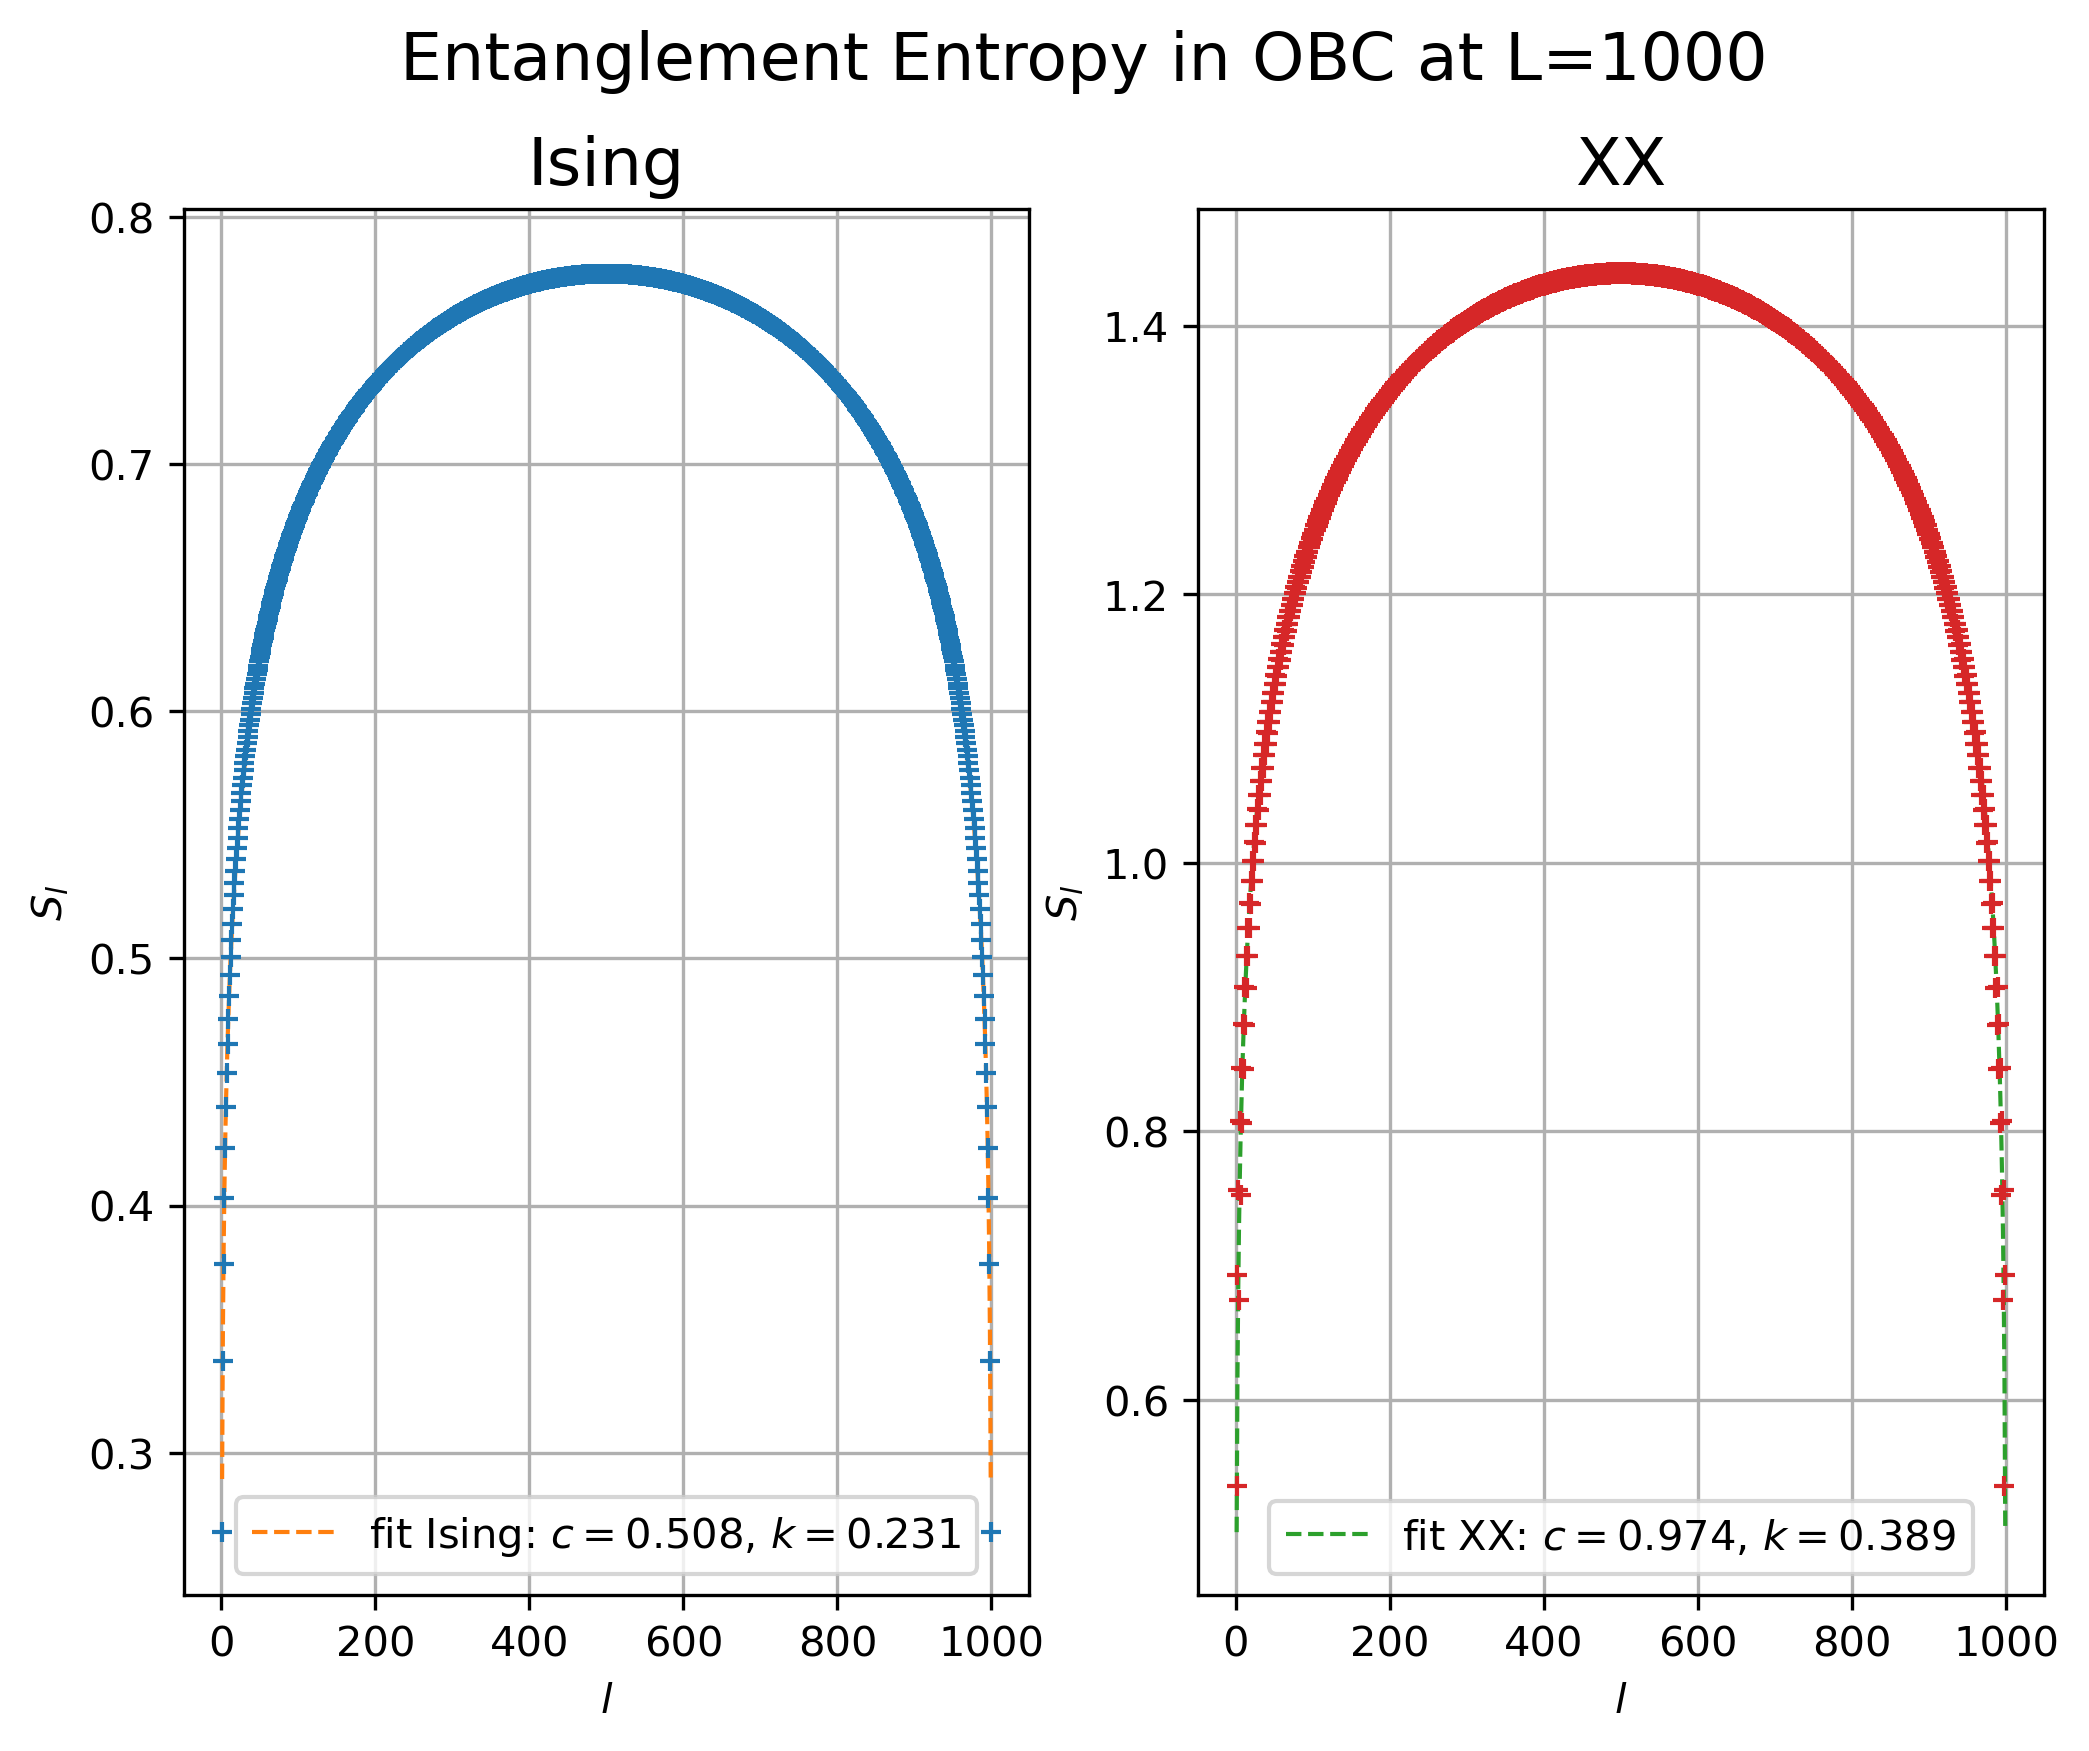

In [ ]:
### Fit

entr_ising = np.load("entr_ising_PBC.npy")
entr_XX = np.load("entr_XX_PBC.npy")

L = 1000
ls = np.arange(L)

def CFT_general(x_, A_, B_, L_):
    return A_/3*np.log(L_/np.pi * np.sin(np.pi*x_/L_)) + B_

fit_CFT = lambda x, a, b : CFT_general(x, a, b, 1000)
l_min = 1

par_ising, cov_ising = sp.optimize.curve_fit(fit_CFT, ls[l_min:], entr_ising[l_min:])
par_XX, cov_XX = sp.optimize.curve_fit(fit_CFT, ls[l_min:], entr_XX[l_min:])

fig = plt.figure(figsize=(8, 6), dpi=300)
plt.suptitle(r"Entanglement Entropy in PBC at L={}".format(L), fontsize=16)

ax = plt.subplot(121)
ax.set_title(r"Ising", fontsize=16)
plt.xlabel(r"$l$")
plt.ylabel(r"$S_{l}$")
plt.plot(ls[l_min:], fit_CFT(ls[l_min:], *par_ising), linestyle="--", linewidth=1, color="C1",
         label="fit Ising: $c=${}, $k=${}".format(np.round(par_ising[0], 3), np.round(par_ising[1], 3)))
plt.plot(ls[l_min:], entr_ising[l_min:], "+", markersize="5", color="C0")
plt.grid()
plt.legend(loc="lower center")

ax = plt.subplot(122)
ax.set_title(r"XX", fontsize=16)
plt.xlabel(r"$l$")
plt.ylabel(r"$S_{l}$")
plt.plot(ls[l_min:], fit_CFT(ls[l_min:], *par_XX), linestyle="--", linewidth=1, color="C2",
         label="fit XX: $c=${}, $k=${}".format(np.round(par_XX[0], 3), np.round(par_XX[1], 3)))
plt.plot(ls[l_min:], entr_XX[l_min:], "+", markersize="5", color="C3")
plt.grid()
plt.legend(loc="lower center")

plt.show()